<a href="https://colab.research.google.com/github/caseym7875/DSCI-478-Erowid/blob/main/Erowid_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Erowid Experience Report Analysis**

Casey Martin, Carlos Mabrey, Olivia Jones, Jacy Werner

Inital Package Loading

In [ ]:
from os import pipe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import zipfile
from google.colab import files

# Report filtering (done locally)

In [ ]:
# Code left in for reference but commented out because needs to be ran locally. Not necessary to run to run analysis.

# reports = pd.read_csv("data/processed/cleaned_reports.csv")
# reports = reports.dropna(subset=['report_text'])

# full_drug_list = pd.read_csv("class and assignments/Drug List.csv")['Drug']

# assigned_reports = reports[reports['substance'].isin(full_drug_list)]

# # Keywords to remove
# keywords = ["Cannabis", "Cannabinoid", "Piracetam", "Alcohol", "Cocaine", "Kratom", "Morphine", "Nitrous Oxide", "Pharms",
#             "delta-8-thc", "Tobacco", "Tryptophan", "5-HTP", "Nicotine", ]

# # Build regex pattern (optional: case-insensitive)
# pattern = '|'.join(keywords)

# # Keep rows that do NOT contain the unwanted keywords
# filtered_df = assigned_reports[~assigned_reports['dose_chart'].str.contains(pattern, case=False, na=False)]

# grouped_drugs = {
#     'LSA': ['LSA', 'Morning Glory', 'H.B. Woodrose'],
#     'Psilocin': ['Mushrooms', '4-AcO-DMT', 'Psilocin', 'Psilocybin'],
#     '4-HO-DET': ['4-HO-DET', '4-AcO-DET'],
#     '4-HO-DiPT': ['4-HO-DiPT', '4-AcO-DiPT'],
#     '4-HO-MET': ['4-HO-MET', '4-AcO-MET'],
#     '4-HO-MiPT': ['4-HO-MiPT', '4-AcO-MiPT'],
#     '5-MeO-DMT': ['5-MeO-DMT', 'Toad Venom'],
#     'Ketamine': ['Ketamine', 'S-Ketamine'],
#     'Amanitas': ['Amanita muscaria', 'Amanita pantherina', 'Amanitas - A. pantherina', 'Amanitas - A. muscaria'],
#     'Mescaline': ['Mescaline', 'Cacti - T. pachanoi', 'Cacti - T. peruvianus', 'Peyote', 'Cacti - T. bridgesii']
# }

# # Flatten the mapping to create a lookup table: alias -> canonical name
# alias_to_canonical = {
#     alias: canonical
#     for canonical, aliases in grouped_drugs.items()
#     for alias in aliases
# }

# # Group substances
# filtered_df['substance'] = filtered_df['substance'].replace(alias_to_canonical)

# # Remove German reports
# non_english_reports = ['Psycholyse-Sitzungen (1968)', 'Psycholyse-Sitzungen (1970) und Folgende Jahre', 'Von Todesangst Bis Unbeschreiblich Schoen', 'Su Elemento Disociativo Es Claro', "La Vision De l'Eternite", 'Ein Hass Auf Die Ganze Menschheit']
# filtered_df = filtered_df[~filtered_df['title'].isin(non_english_reports)]

# substance_counts = filtered_df['substance'].value_counts()

# filtered_df.to_csv("data/processed/psychedelic_reports.csv", index=False)

# Report loading and assignment selection

In [ ]:
# Load reports from zip file in Github

data_dir = '/content/data'
os.makedirs(data_dir, exist_ok=True)

zip_url = 'https://github.com/caseym7875/DSCI-478-Erowid/raw/main/psychedelic_reports.zip'
zip_path = os.path.join(data_dir, 'psychedelic_reports.zip')
!wget {zip_url} -O {zip_path}

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

reports = pd.read_csv('/content/data/psychedelic_reports.csv')

--2025-05-07 18:03:21--  https://github.com/caseym7875/DSCI-478-Erowid/raw/main/psychedelic_reports.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/caseym7875/DSCI-478-Erowid/main/psychedelic_reports.zip [following]
--2025-05-07 18:03:22--  https://raw.githubusercontent.com/caseym7875/DSCI-478-Erowid/main/psychedelic_reports.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17937056 (17M) [application/zip]
Saving to: ‘/content/data/psychedelic_reports.zip’

/content/data/psych 100%[===================>]  17.11M  69.8MB/s    in 0.2s    

2025-05-07 18:03:22 (69.8 MB/s) - ‘/content/data/psyc

In [ ]:
drug_list = pd.read_csv("https://raw.githubusercontent.com/caseym7875/DSCI-478-Erowid/refs/heads/main/Drug%20List%20Grouped.csv")['Drug']
full_assigned_list = pd.read_csv("https://raw.githubusercontent.com/caseym7875/DSCI-478-Erowid/refs/heads/main/Drug%20Assignments%20Grouped.csv")

def set_assignment(name='none'):
  # Function to set to specific substance classes.
  # Default behavior is to set to every substance.

  if(name != 'none'):
    assigned_list = full_assigned_list[name].dropna()
  else:
    assigned_list = drug_list.copy()

  filtered_reports = reports[reports['substance'].isin(assigned_list)]
  return filtered_reports, assigned_list


filtered_reports, assigned_list = set_assignment()

#Sentiment Analysis

In [ ]:
# Run reports through longformer classifier
# Results already computed and loaded from github to not repeat very long runtime.

# Set to true to run analysis
compute_sentiment = False

if(compute_sentiment == True):
  import torch
  from transformers import AutoTokenizer, AutoModelForSequenceClassification
  from torch.utils.data import DataLoader, TensorDataset

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_name = 'spacesedan/sentiment-analysis-longformer'
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
  model.eval()

  from tqdm.auto import tqdm

  def sentiment_classifier_fast(df, max_length=4096, batch_size=16):
      texts = df["report_text"].tolist()

      # Tokenize
      encodings = tokenizer(
          texts,
          padding=True,
          truncation=True,
          max_length=max_length,
          return_tensors="pt"
      )

      dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
      loader = DataLoader(dataset, batch_size=batch_size)

      all_probs = []

      model.eval()
      with torch.no_grad():
          for batch in tqdm(loader, desc="Sentiment Inference", leave=True):
              input_ids, attention_mask = [b.to(device) for b in batch]
              outputs = model(input_ids=input_ids, attention_mask=attention_mask)
              probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
              all_probs.extend(probs.cpu().numpy())

      label_names = [model.config.id2label[i] for i in range(len(model.config.id2label))]
      probs_df = pd.DataFrame(all_probs, columns=label_names)
      return probs_df

  probs_df = sentiment_classifier_fast(filtered_reports)
  probs_df['substance'] = filtered_reports['substance']

  # Compute mean per drug
  summary_df = probs_df.groupby('substance').mean()
  summary_df

Clear memory

In [ ]:
#torch.cuda.empty_cache()
#torch.cuda.ipc_collect()

Export sentiment results

In [ ]:
#summary_df.to_csv('sentiment_longformer_results.csv')

# Sentiment Visulization

In [ ]:
# Horizontal stacked bar chart

def horizontal_stacked_bar(filtered_results, subst_class=""):

  filtered_results = filtered_results.set_index('substance')

  custom_colors = ['#d73027',  # very negative (red)
                  '#fc8d59',  # negative (orange)
                  '#e0e0e0',  # neutral (gray)
                  '#91cf60',  # positive (lime green)
                  '#1a9850']  # very positive (green)

  filtered_results.plot(
      kind='barh',
      stacked=True,
      figsize=(10, 8),
      color=custom_colors
  )
  plt.title('Sentiment Distribution for '+subst_class, fontweight='bold')
  plt.xlabel('Proportion of Sentiment', fontweight='bold')
  plt.ylabel('Substance', fontweight='bold')

  #legend
  import matplotlib.patches as mpatches
  legend_labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']
  legend_colors = custom_colors
  patches = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
  plt.legend(handles=patches, title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.tight_layout()
  plt.show()

In [ ]:
# Bar charts for each substance and classification category

def bar_charts(filtered_results, subst_class=""):

  df = filtered_results.reset_index()

  categories = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
  x = np.arange(len(df['substance']))
  bar_width = 0.15
  fig, ax = plt.subplots(figsize=(12, 6))

  # color scale: red and green
  colors = ['#d73027', '#fc8d59', '#e0e0e0', '#91cf60', '#1a9850']

  for i, cat in enumerate(categories):
      ax.bar(x + i * bar_width, df[cat], width=bar_width, label=cat.title(), color=colors[i])


  ax.set_xticks(x + bar_width * 2)
  ax.set_xticklabels(df['substance'], rotation=45, ha='right')

  fig, axs = plt.subplots(1, 5, figsize=(20, 4))


  colors = ['#d73027', '#fc8d59', '#e0e0e0', '#91cf60', '#1a9850']


  for i, cat in enumerate(categories):
      df.plot(
        x='substance',
        y=cat,
        kind='bar',
        ax=axs[i],
        title=cat.title(),
        legend=False,
        color=colors[i],
        edgecolor='black',
        alpha=0.85
    )
      axs[i].set_title(cat.title(), fontweight='bold')
      axs[i].grid(axis='y', linestyle='--', alpha=0.3)
      axs[i].set_ylim(0, 0.4)
      axs[i].spines['top'].set_visible(False)
      axs[i].spines['right'].set_visible(False)

  ax.set_title('Sentiment Distribution by Category for '+subst_class, fontweight='bold')
  ax.set_xlabel('Substance')
  ax.set_ylabel('Proportion of Sentiment')
  ax.legend(
      title='Sentiment',
      bbox_to_anchor=(1.02, 1),
      loc='upper left',
      fontsize='small',
      title_fontsize='small'
  )
  plt.tight_layout()
  plt.show()


In [ ]:
# Clustered heatmap of results

def sentiment_heatmap(filtered_results, size1=12, size2=10, subst_class=""):

  heatmap_data = filtered_results.reset_index()
  heatmap_data = heatmap_data.set_index('substance')
  heatmap_data = heatmap_data.drop(columns=['index'])

  heatmap_data.columns = [col.title() for col in heatmap_data.columns]

  g = sns.clustermap(
      heatmap_data,
      cmap='coolwarm',
      annot=True,
      figsize=(size1, size2),
      col_cluster=False,
      cbar_pos=(1.02, 0.3, 0.03, 0.4)
  )

  g.ax_heatmap.set_title('Sentiment Heatmap of '+subst_class, fontsize=16, fontweight='bold', pad=10)

  plt.show()


In [ ]:
def min_max_sentiment(df):
  # Display maximum and minimum substance for each sentiment category

  results = {}
  for column in df.columns[1:]:
      max_idx = df[column].idxmax()
      min_idx = df[column].idxmin()
      results[column] = {
          'max': (df.loc[max_idx, 'substance'], df.loc[max_idx, column]),
          'min': (df.loc[min_idx, 'substance'], df.loc[min_idx, column])
      }

  # Display results
  for sentiment, extremes in results.items():
      print(f"{sentiment.capitalize()}:")
      print(f"  Min: {extremes['min'][0]} ({extremes['min'][1]:.6f})")
      print(f"  Max: {extremes['max'][0]} ({extremes['max'][1]:.6f})\n")


In [ ]:
# Load pre-computed sentitment analysis results
sentiment_longformer = pd.read_csv("https://raw.githubusercontent.com/caseym7875/DSCI-478-Erowid/refs/heads/main/sentiment_longformer_results.csv")

All Substances

In [ ]:
# Set to all substances
deprecated_reports, assigned_list = set_assignment()

# Set assignment
filtered_results = sentiment_longformer[sentiment_longformer['substance'].isin(assigned_list)]
filtered_results

,substance,very negative,negative,neutral,positive,very positive
0,25B-NBOMe,0.216779,0.276025,0.202012,0.167874,0.137310
1,25C-NBOMe,0.196700,0.267001,0.207302,0.194868,0.134129
2,25I-NBOMe,0.247101,0.261455,0.178180,0.157627,0.155637
3,2C-B,0.182661,0.256254,0.204544,0.198181,0.158360
4,2C-C,0.151447,0.254625,0.223582,0.237889,0.132457
5,2C-D,0.154277,0.301857,0.237109,0.200604,0.106154
6,2C-E,0.205580,0.263424,0.203260,0.178293,0.149443
7,2C-I,0.174104,0.247999,0.208983,0.206846,0.162068
8,2C-P,0.220034,0.261830,0.196673,0.173869,0.147593
9,2C-T-2,0.186911,0.265691,0.208589,0.184384,0.154425


In [ ]:
min_max_sentiment(filtered_results)

Very negative:
  Min: 4-HO-DET (0.101951)
  Max: PCP (0.335826)

Negative:
  Min: 4-HO-DET (0.188471)
  Max: DiPT (0.355967)

Neutral:
  Min: PCP (0.155383)
  Max: DOM (0.240223)

Positive:
  Min: PCP (0.085658)
  Max: 4-HO-DET (0.309749)

Very positive:
  Min: MDAI (0.076583)
  Max: MDMA (0.228217)



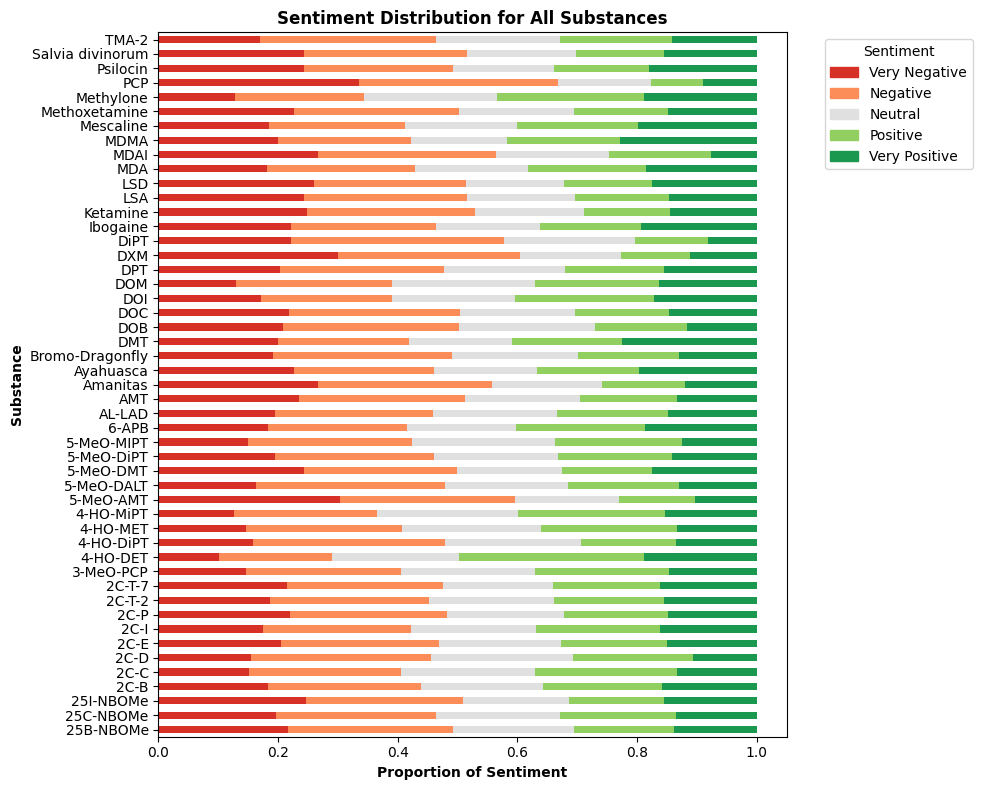

In [ ]:
horizontal_stacked_bar(filtered_results, subst_class='All Substances')

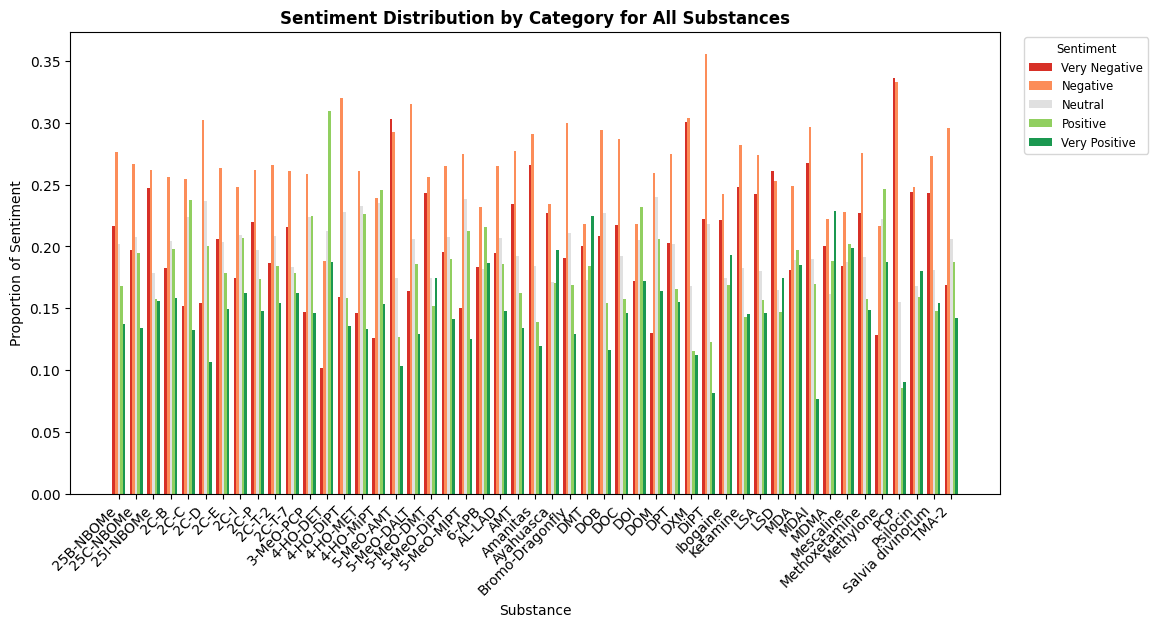

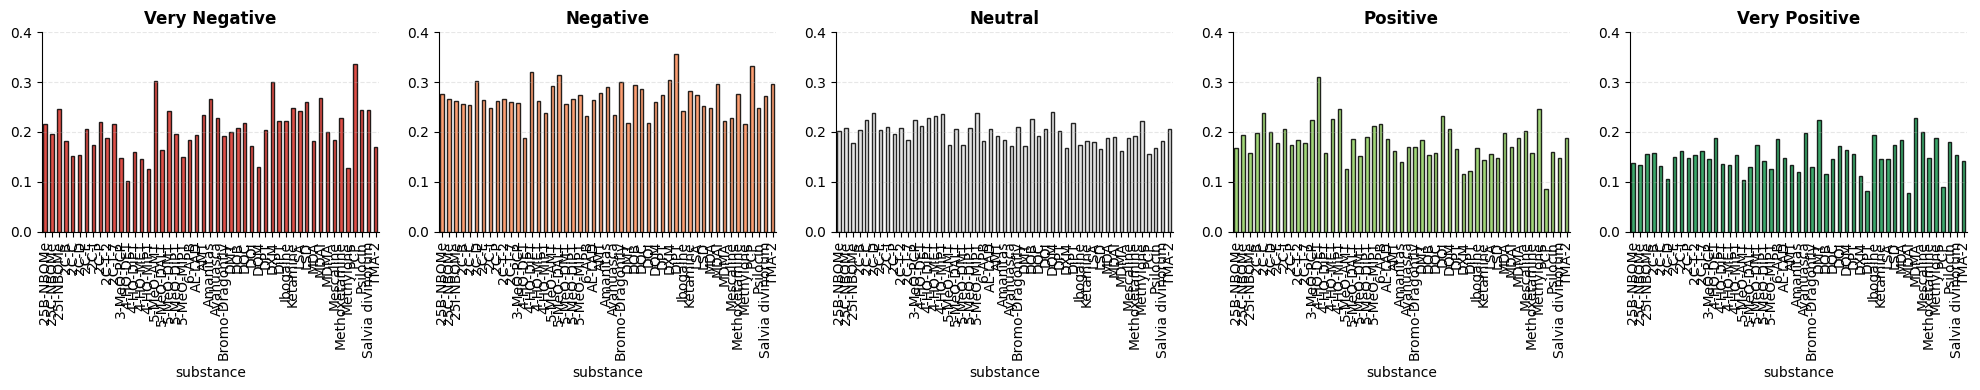

In [ ]:
bar_charts(filtered_results, subst_class='All Substances')

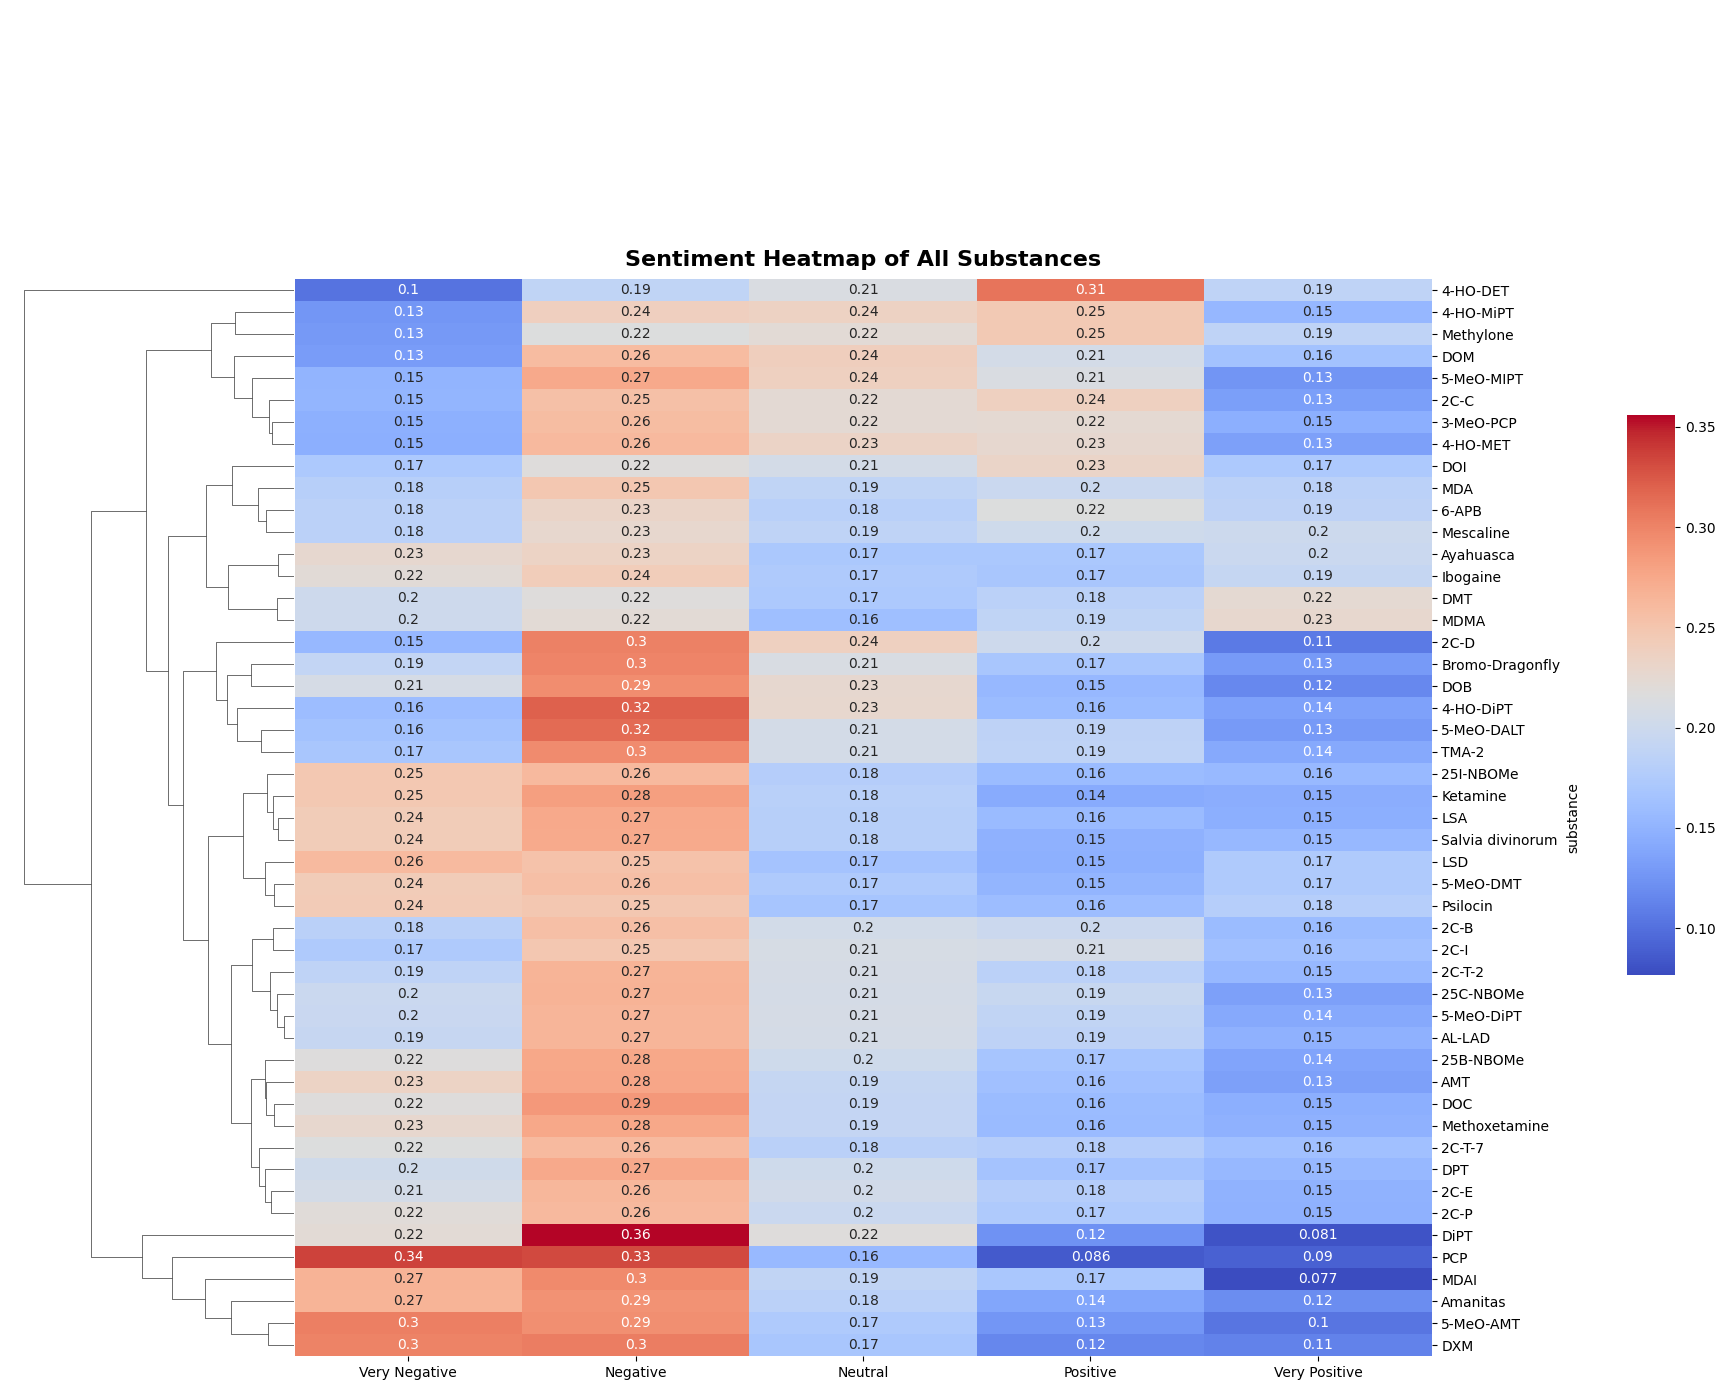

In [ ]:
sentiment_heatmap(filtered_results, 16, 14, subst_class='All Substances')

Entactogens

In [ ]:
# Set to Entactogens
deprecated_reports, assigned_list = set_assignment('Casey')
assigned_list =  assigned_list.iloc[:5]

# Set assignment
filtered_results = sentiment_longformer[sentiment_longformer['substance'].isin(assigned_list)]

In [ ]:
min_max_sentiment(filtered_results)

Very negative:
  Min: Methylone (0.128148)
  Max: MDAI (0.267277)

Negative:
  Min: Methylone (0.216095)
  Max: MDAI (0.296509)

Neutral:
  Min: MDMA (0.161453)
  Max: Methylone (0.222092)

Positive:
  Min: MDAI (0.169615)
  Max: Methylone (0.246044)

Very positive:
  Min: MDAI (0.076583)
  Max: MDMA (0.228217)



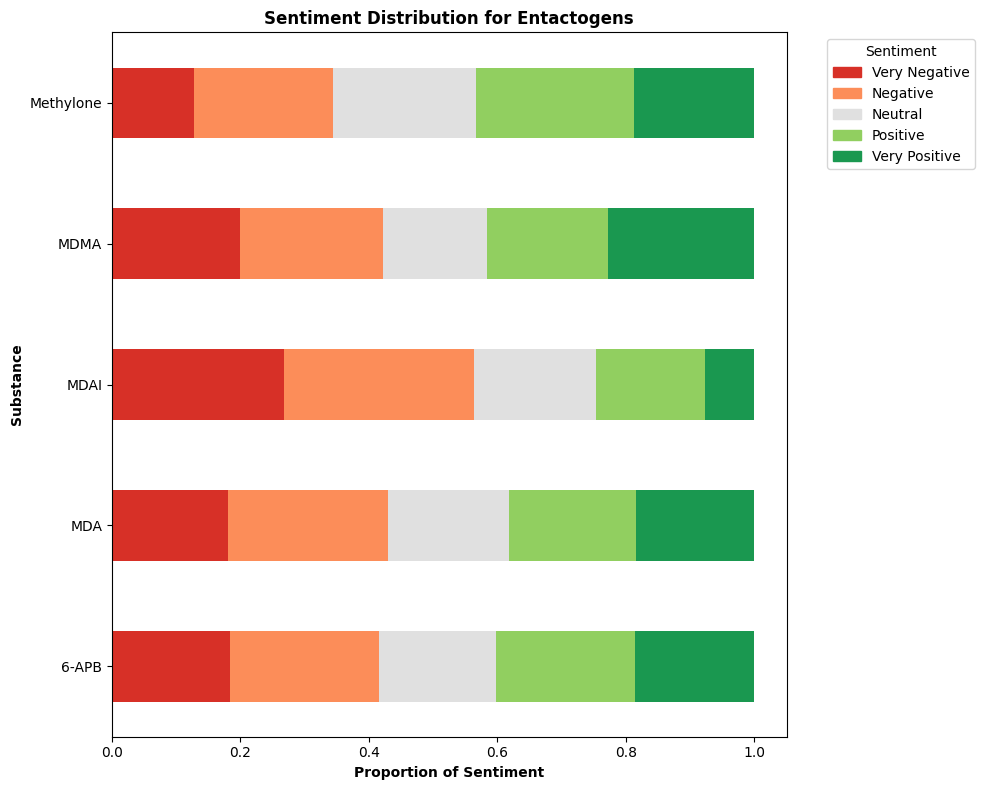

In [ ]:
horizontal_stacked_bar(filtered_results, subst_class='Entactogens')

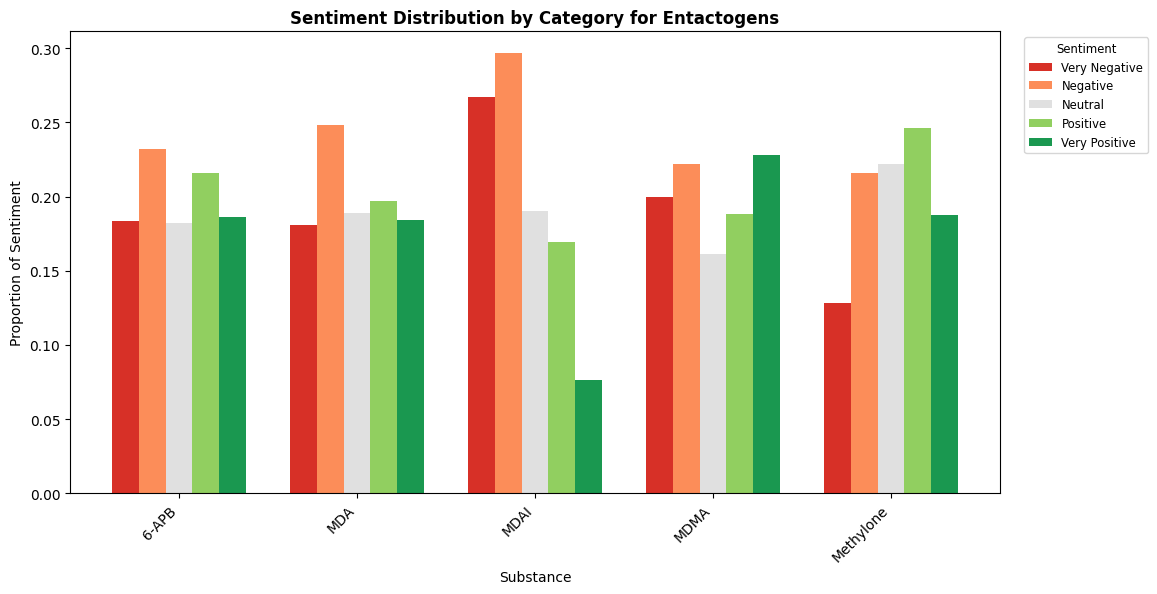

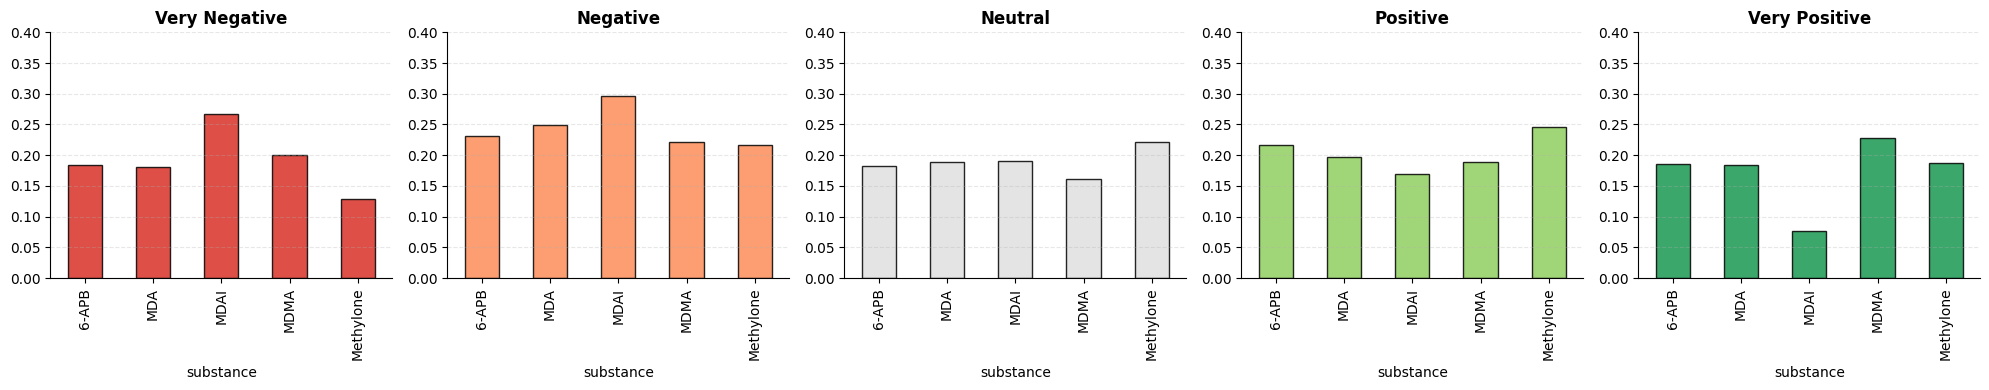

In [ ]:
bar_charts(filtered_results, subst_class='Entactogens')

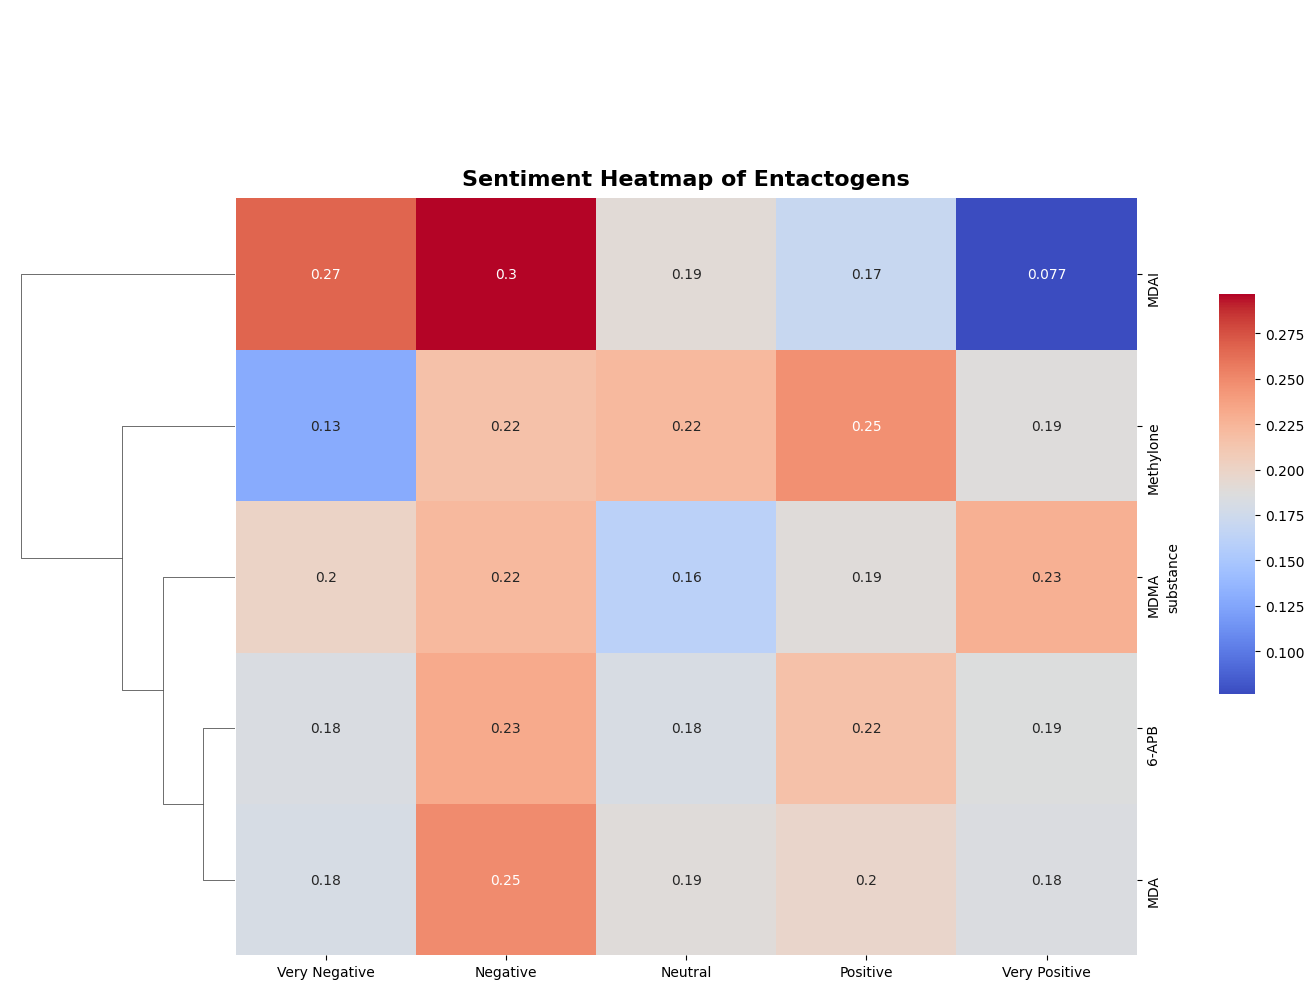

In [ ]:
sentiment_heatmap(filtered_results, subst_class='Entactogens')

Lysergamides

In [ ]:
# Set to Lysergamides
deprecated_reports, assigned_list = set_assignment('Casey')
assigned_list =  assigned_list.iloc[5:8]

# Set assignment
filtered_results = sentiment_longformer[sentiment_longformer['substance'].isin(assigned_list)]

In [ ]:
min_max_sentiment(filtered_results)

Very negative:
  Min: AL-LAD (0.194446)
  Max: LSD (0.260755)

Negative:
  Min: LSD (0.252666)
  Max: LSA (0.274118)

Neutral:
  Min: LSD (0.165029)
  Max: AL-LAD (0.206914)

Positive:
  Min: LSD (0.146817)
  Max: AL-LAD (0.185781)

Very positive:
  Min: LSA (0.146385)
  Max: LSD (0.174732)



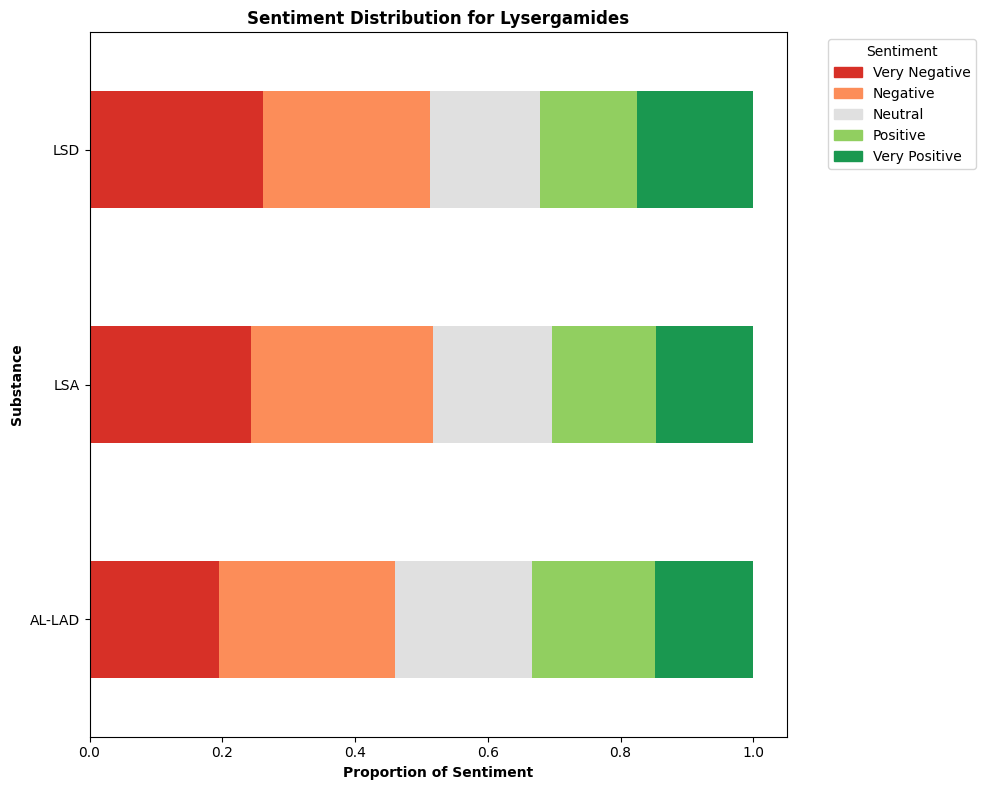

In [ ]:
horizontal_stacked_bar(filtered_results, subst_class='Lysergamides')

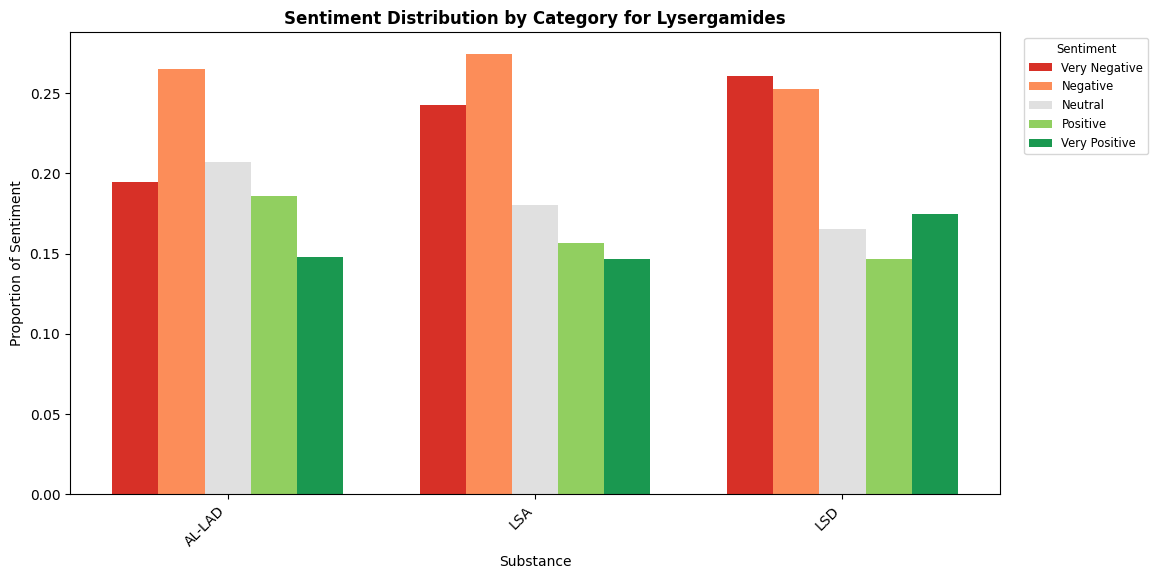

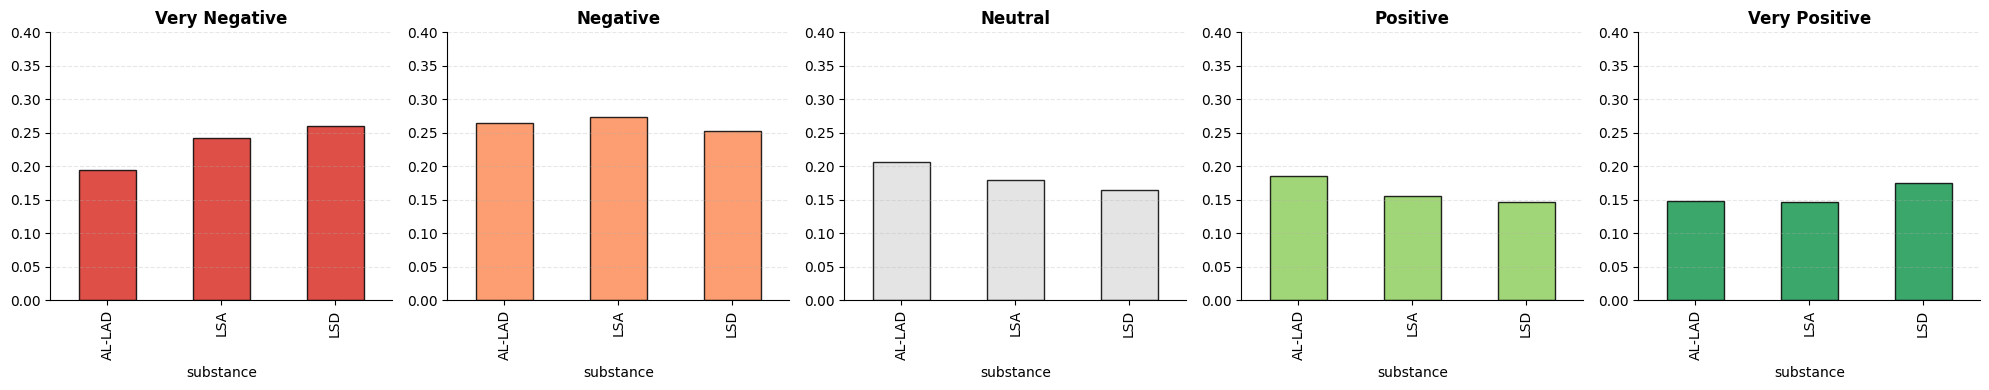

In [ ]:
bar_charts(filtered_results, subst_class='Lysergamides')

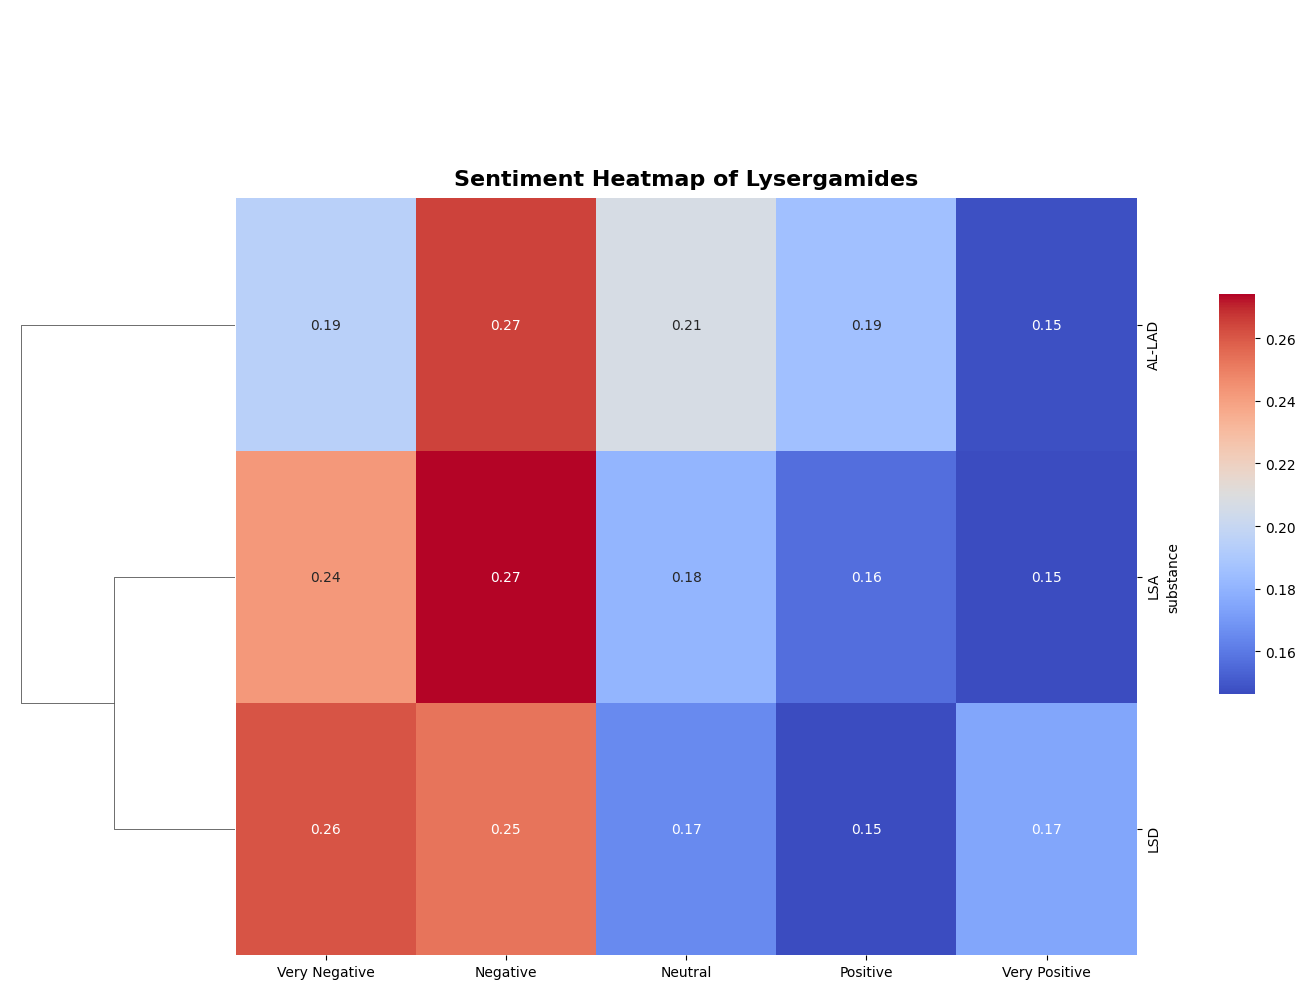

In [ ]:
sentiment_heatmap(filtered_results, subst_class='Lysergamides')

Phenethylamines

In [ ]:
# Set to Lysergamides
deprecated_reports, assigned_list = set_assignment('Carlos')

# Set assignment
filtered_results = sentiment_longformer[sentiment_longformer['substance'].isin(assigned_list)]

In [ ]:
min_max_sentiment(filtered_results)

Very negative:
  Min: DOM (0.130089)
  Max: 25I-NBOMe (0.247101)

Negative:
  Min: DOI (0.217784)
  Max: 2C-D (0.301857)

Neutral:
  Min: 25I-NBOMe (0.178180)
  Max: DOM (0.240223)

Positive:
  Min: DOB (0.154296)
  Max: 2C-C (0.237889)

Very positive:
  Min: 2C-D (0.106154)
  Max: Mescaline (0.199085)



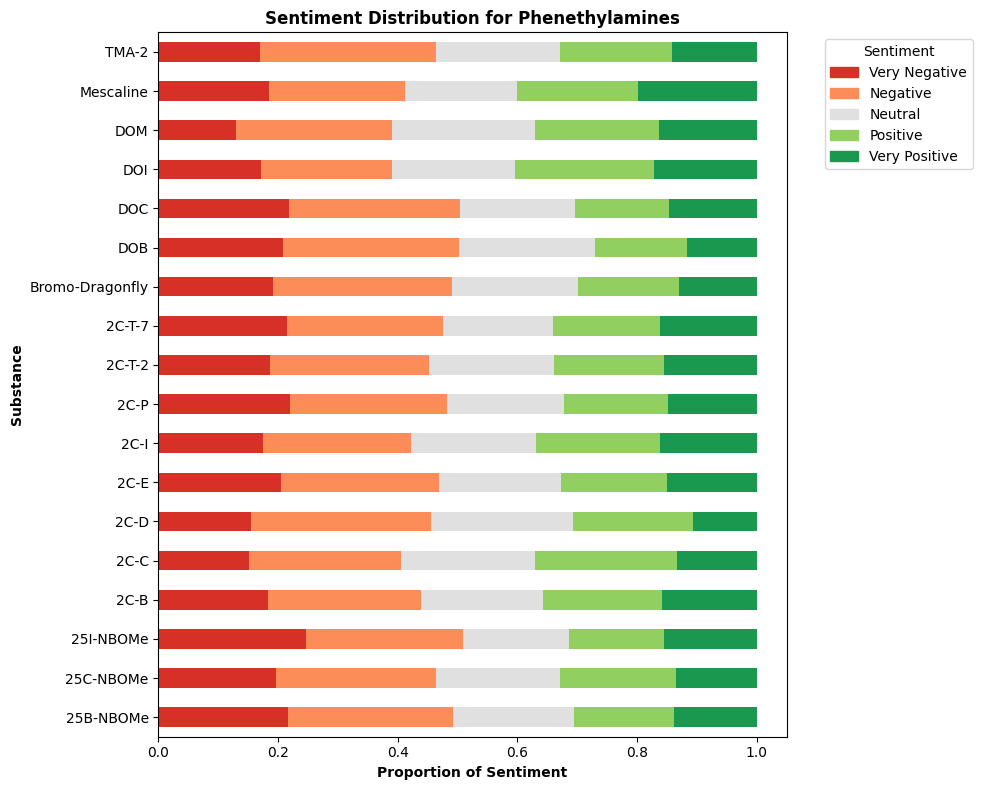

In [ ]:
horizontal_stacked_bar(filtered_results, subst_class='Phenethylamines')

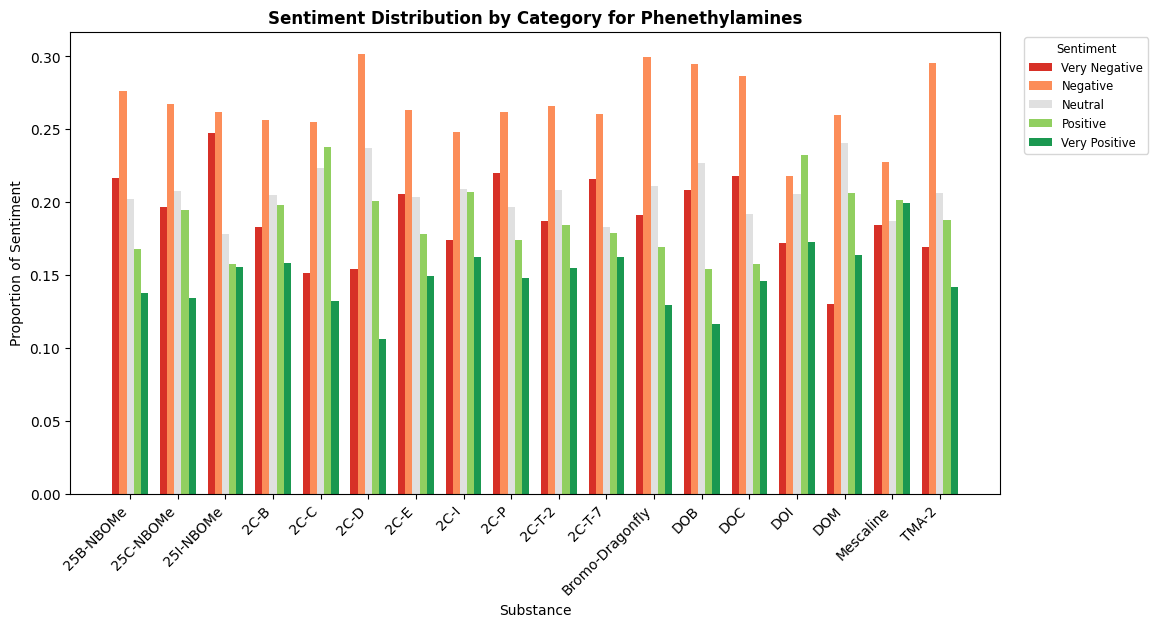

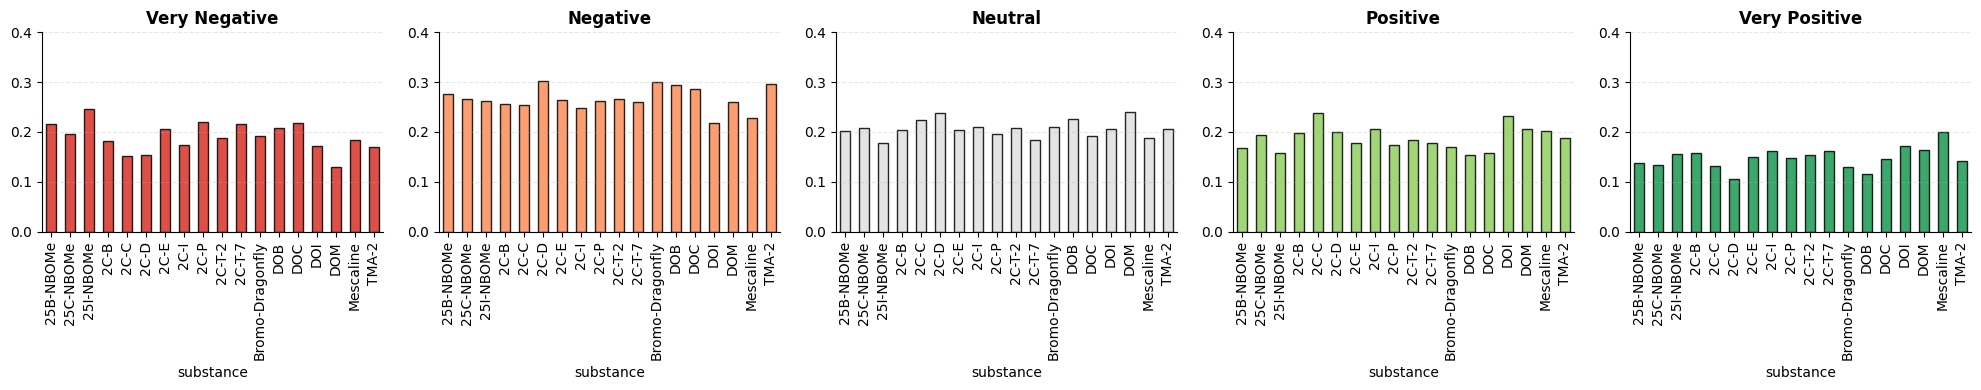

In [ ]:
bar_charts(filtered_results, subst_class='Phenethylamines')

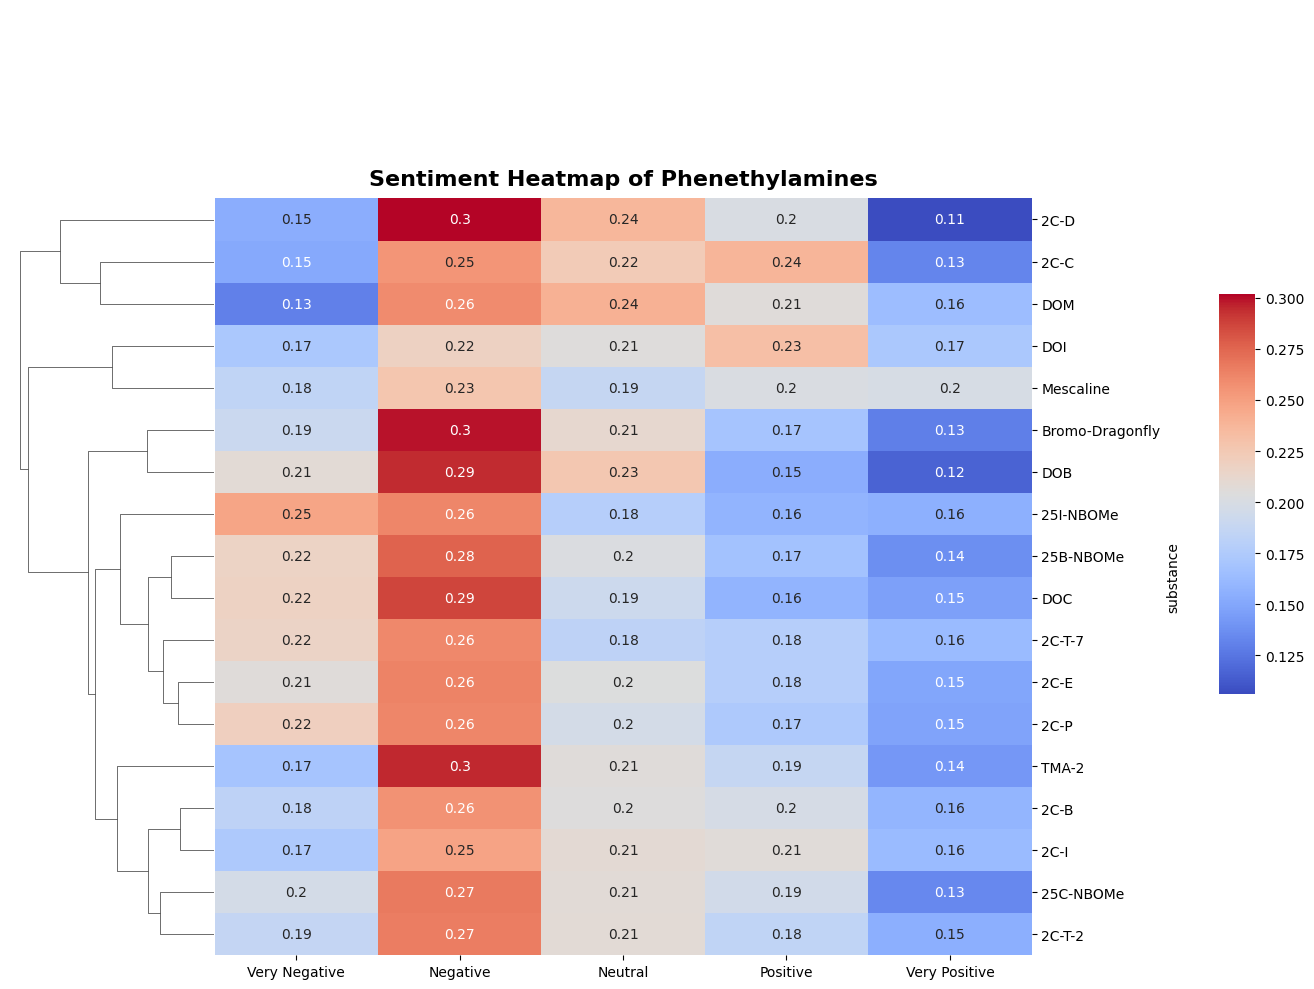

In [ ]:
sentiment_heatmap(filtered_results, subst_class='Phenethylamines')

Tryptamines

In [ ]:
# Set to Lysergamides
deprecated_reports, assigned_list = set_assignment('Olivia')

# Set assignment
filtered_results = sentiment_longformer[sentiment_longformer['substance'].isin(assigned_list)]

In [ ]:
min_max_sentiment(filtered_results)

Very negative:
  Min: 4-HO-DET (0.101951)
  Max: 5-MeO-AMT (0.303209)

Negative:
  Min: 4-HO-DET (0.188471)
  Max: DiPT (0.355967)

Neutral:
  Min: Psilocin (0.168233)
  Max: 5-MeO-MIPT (0.237936)

Positive:
  Min: DiPT (0.122433)
  Max: 4-HO-DET (0.309749)

Very positive:
  Min: DiPT (0.081441)
  Max: DMT (0.224966)



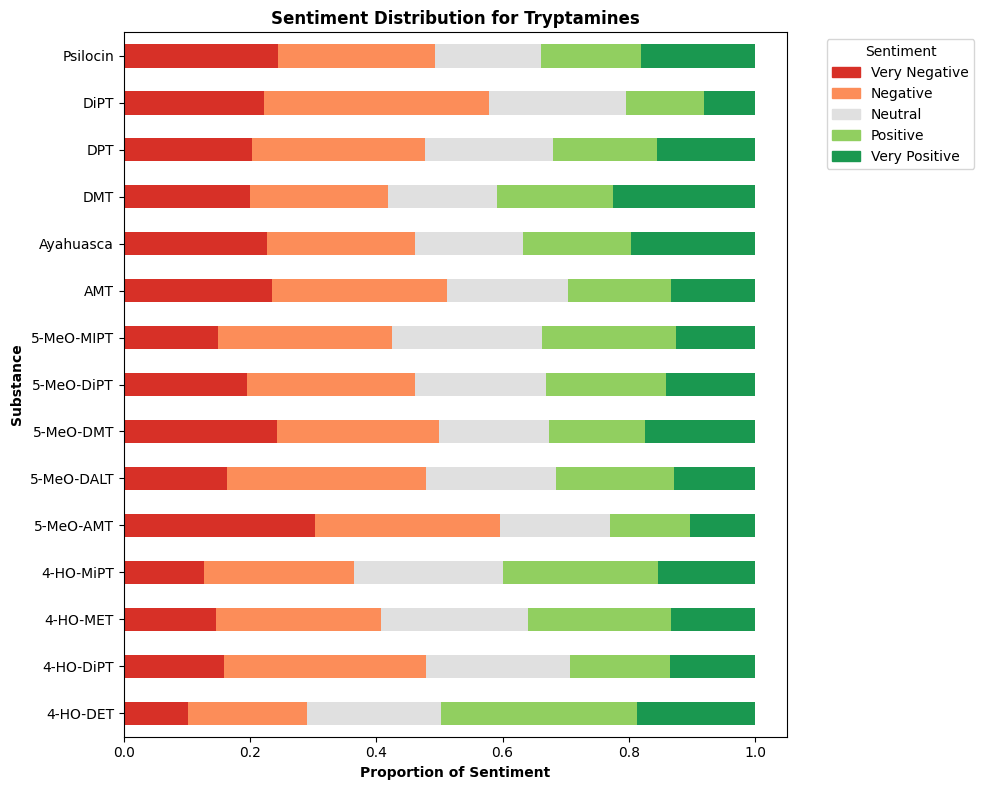

In [ ]:
horizontal_stacked_bar(filtered_results, subst_class='Tryptamines')

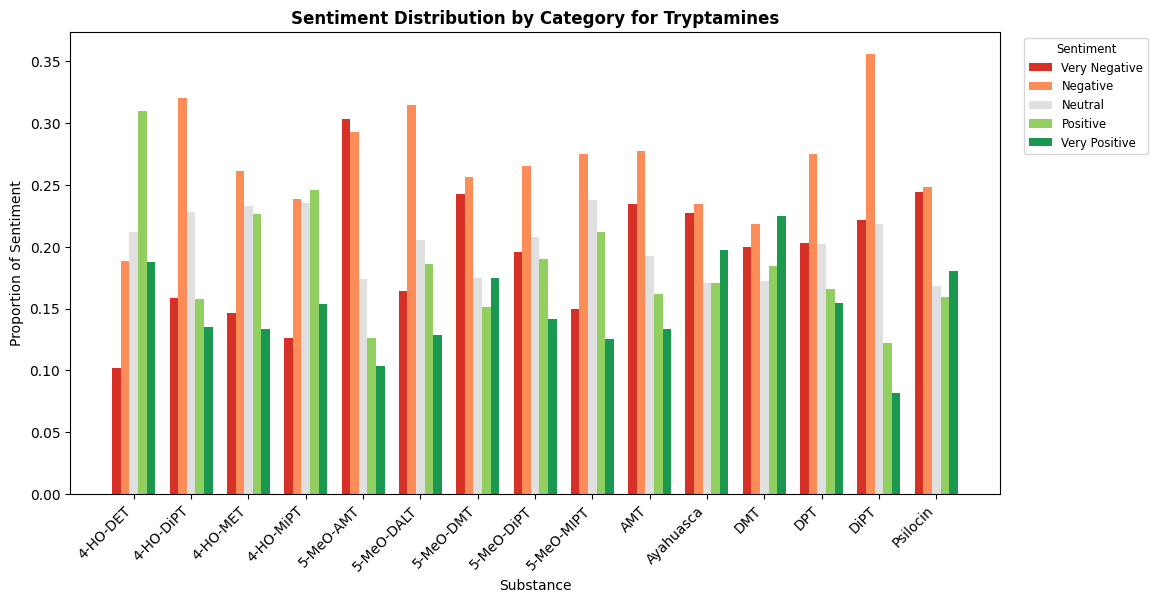

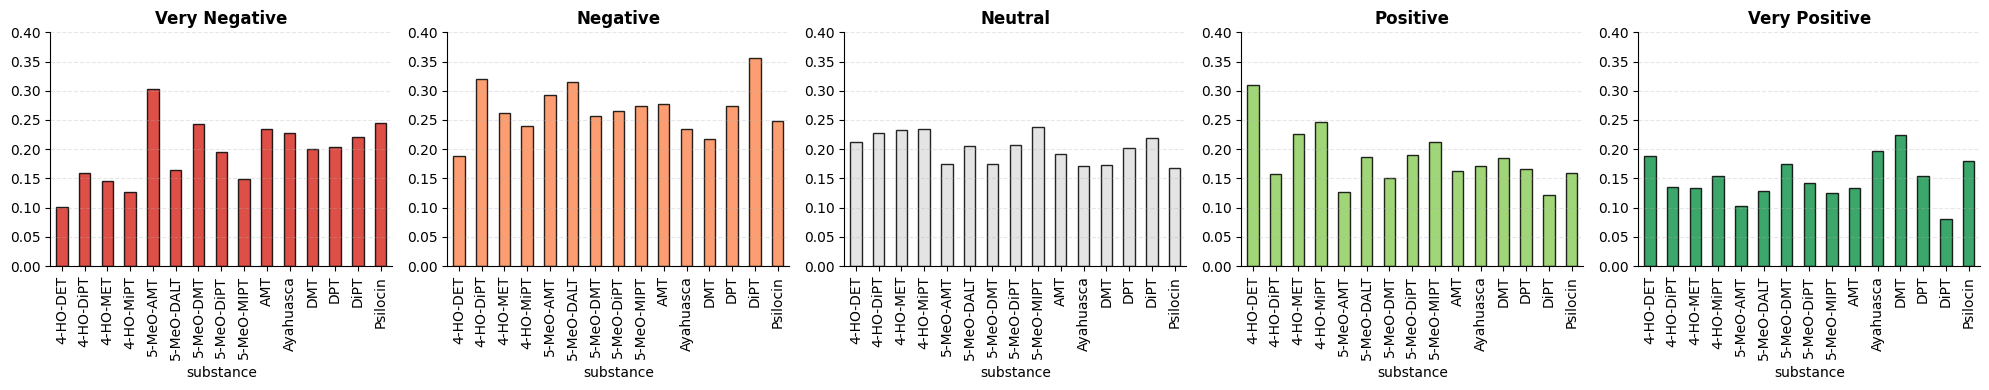

In [ ]:
bar_charts(filtered_results, subst_class='Tryptamines')

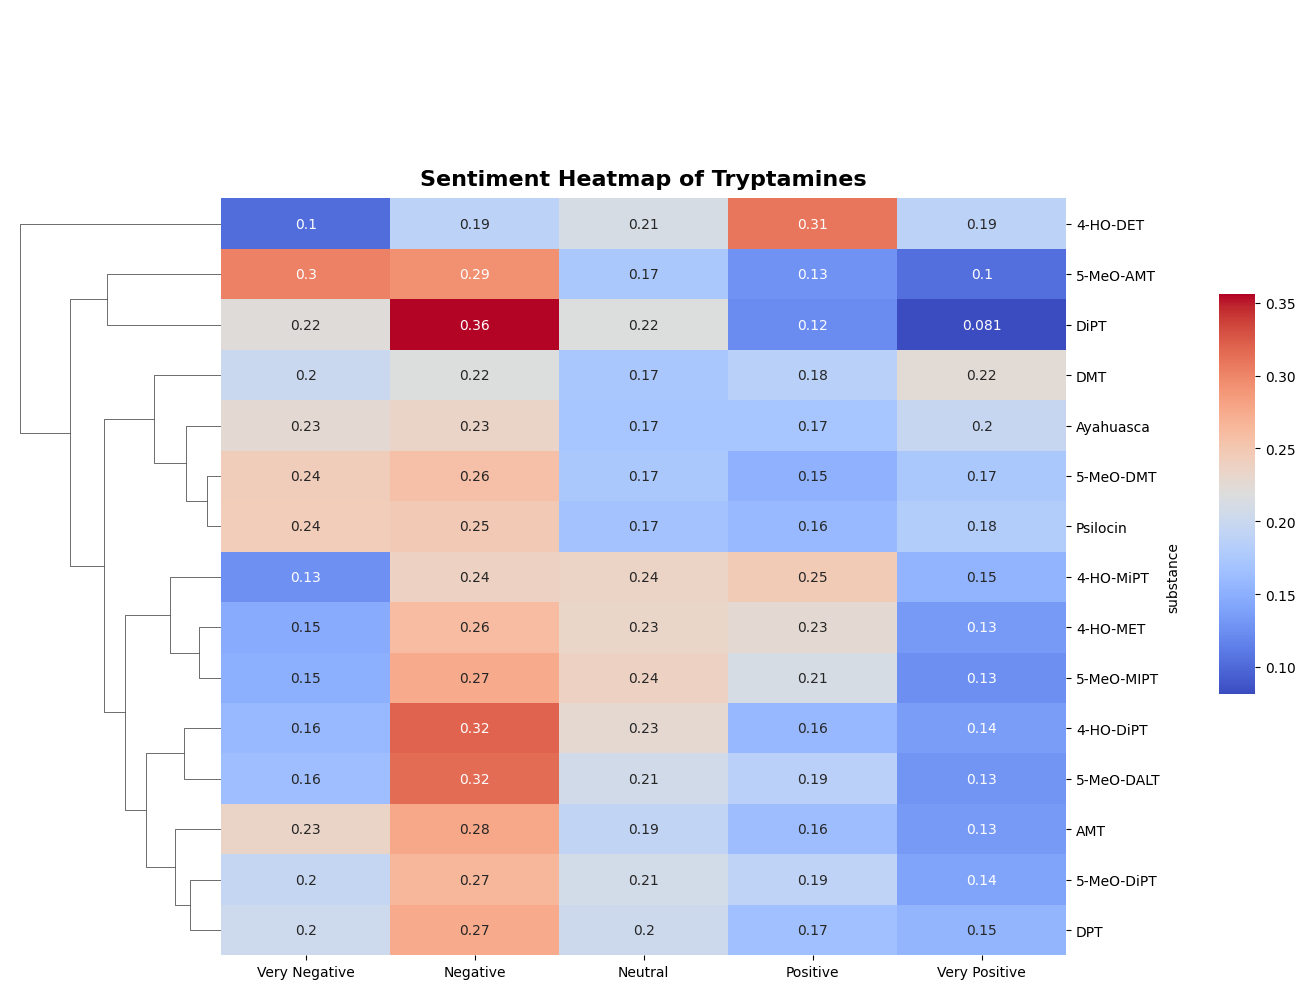

In [ ]:
sentiment_heatmap(filtered_results, subst_class='Tryptamines')

Dissociatives

In [ ]:
# Set to Lysergamides
deprecated_reports, assigned_list = set_assignment('Jacy')

# Set assignment
filtered_results = sentiment_longformer[sentiment_longformer['substance'].isin(assigned_list)]

In [ ]:
min_max_sentiment(filtered_results)

Very negative:
  Min: 3-MeO-PCP (0.146916)
  Max: PCP (0.335826)

Negative:
  Min: Ibogaine (0.242450)
  Max: PCP (0.332907)

Neutral:
  Min: PCP (0.155383)
  Max: 3-MeO-PCP (0.223473)

Positive:
  Min: PCP (0.085658)
  Max: 3-MeO-PCP (0.224969)

Very positive:
  Min: PCP (0.090226)
  Max: Ibogaine (0.192962)



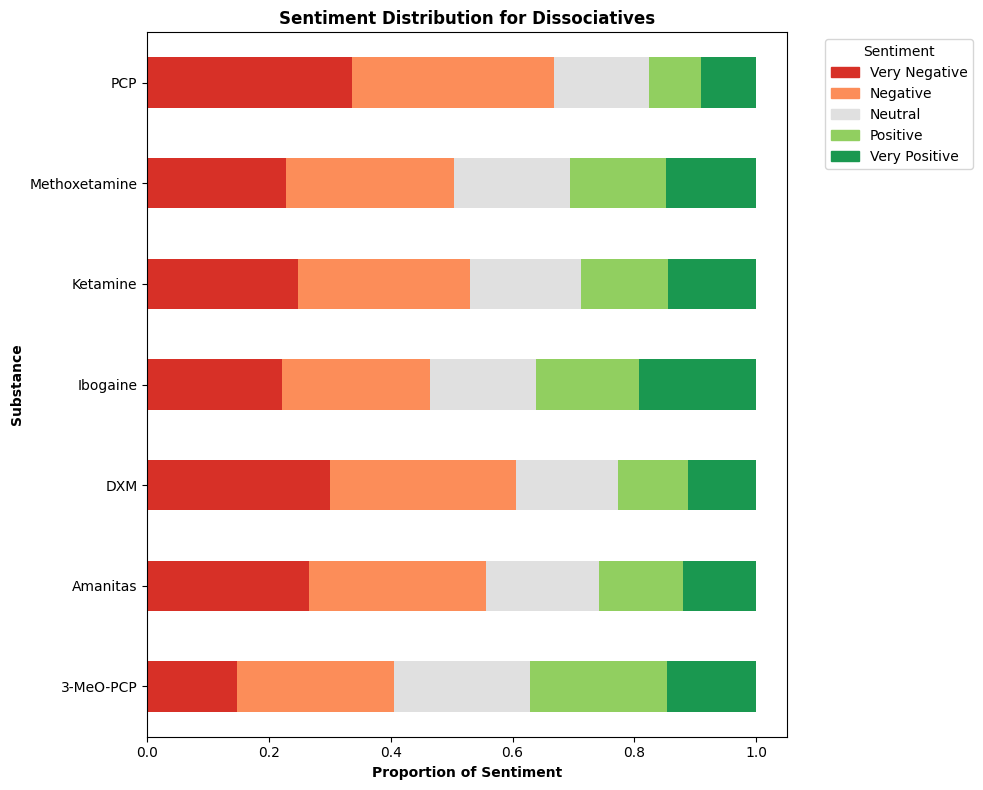

In [ ]:
horizontal_stacked_bar(filtered_results, subst_class='Dissociatives')

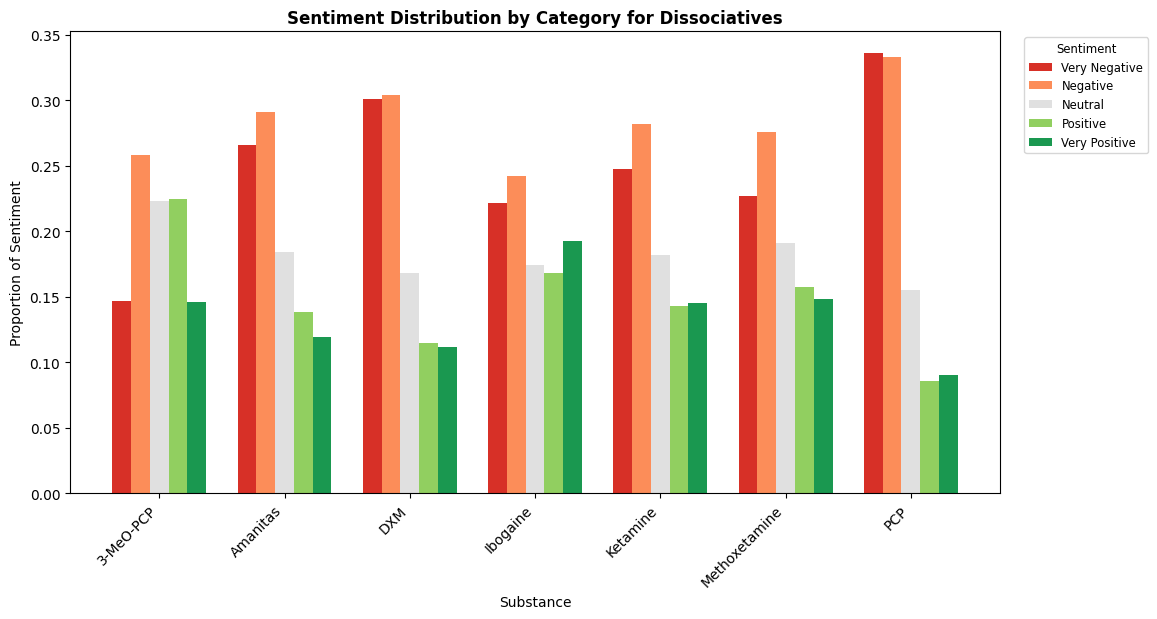

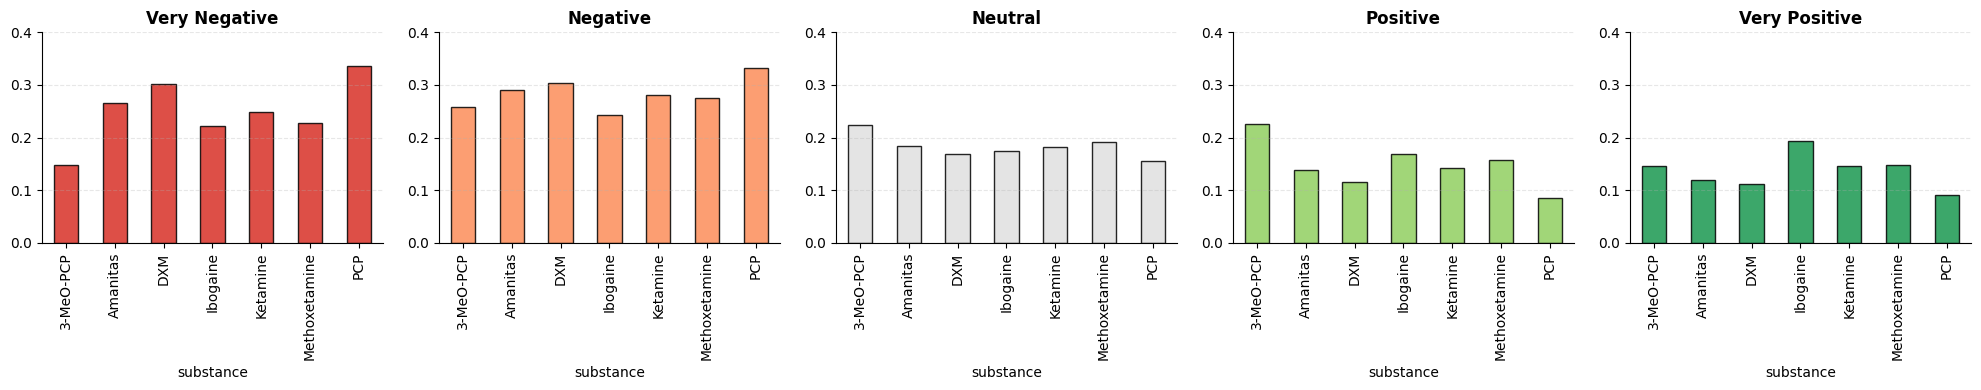

In [ ]:
bar_charts(filtered_results, subst_class='Dissociatives')

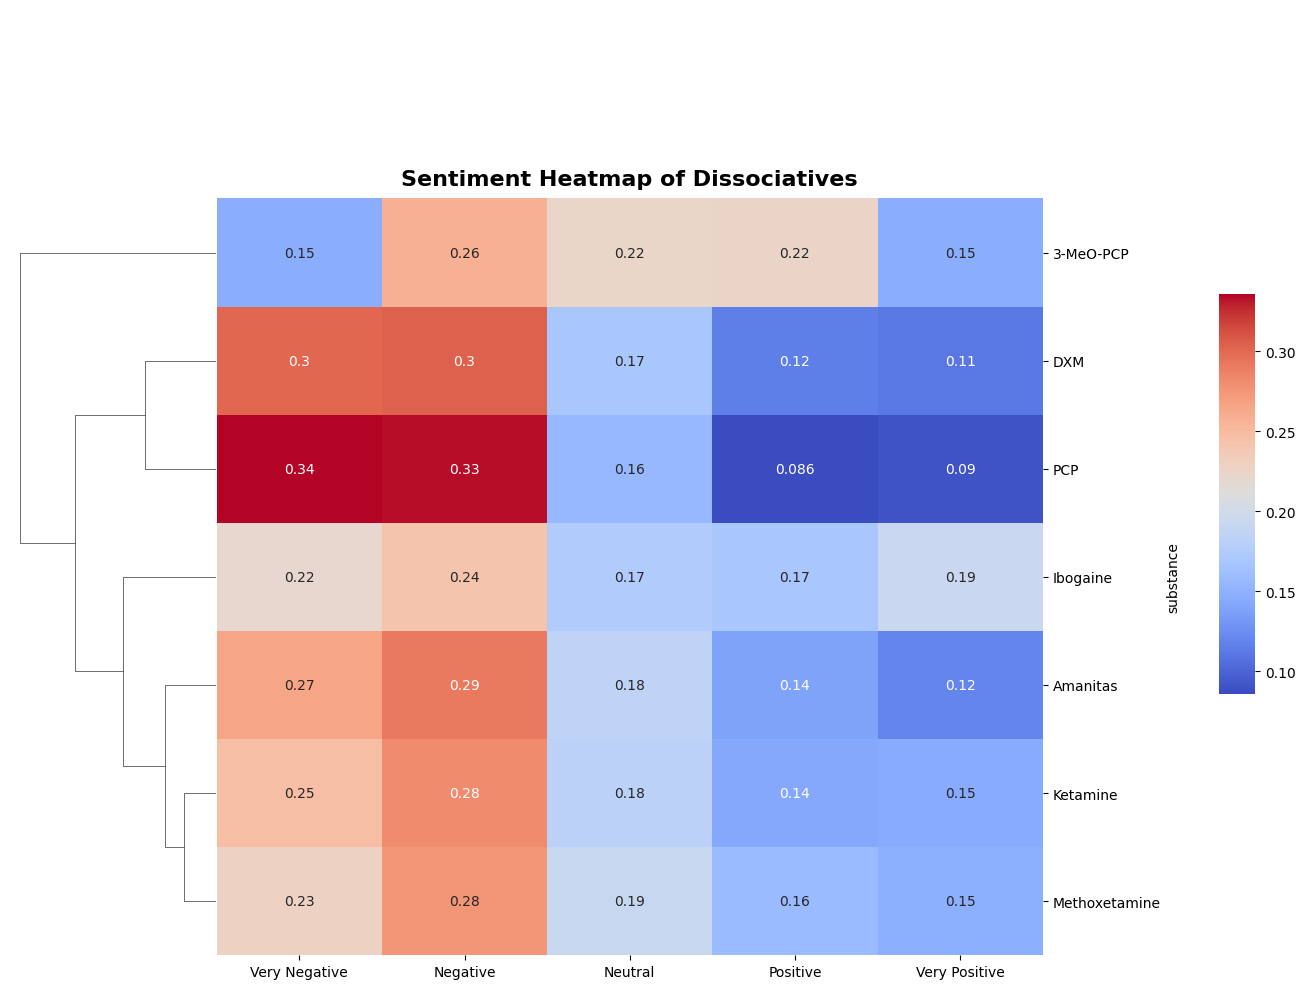

In [ ]:
sentiment_heatmap(filtered_results, subst_class='Dissociatives')

#Latent Semantic Analysis

In [ ]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# Remove words that are related to substance names including slang variations, routes of administration, personal names and personal pronouns
words_to_exclude = pd.read_csv("https://raw.githubusercontent.com/caseym7875/DSCI-478-Erowid/refs/heads/main/words%20to%20exclude.csv").iloc[:,0]
words_to_exclude = set(words_to_exclude)

# Add manually because unicode weirdness
words_to_exclude.add('anané')

In [ ]:
nltk.download('punkt_tab')
nltk.download('wordnet')

# Preprocessing function
lemmatizer = WordNetLemmatizer()
def preprocess(text: str) -> list:

    tokens = [lemmatizer.lemmatize(tok.lower()) for tok in word_tokenize(text) if tok.isalpha()]
    return [tok for tok in tokens if len(tok) >= 3 and tok not in words_to_exclude]

def LSA_analysis(reports, drug_list = drug_list):


  # TF-IDF on individual reports
  corpus = reports['processed_text'].apply(' '.join)
  tfidf_vec = TfidfVectorizer()
  tfidf_indiv = tfidf_vec.fit_transform(corpus)
  tfidf_indiv_df = pd.DataFrame(tfidf_indiv.toarray(), columns=tfidf_vec.get_feature_names_out())


  # Grouped corpus
  grouped_corpus = (
      reports.groupby('substance')['processed_text']
      .apply(lambda lists: ' '.join(tok for tokens in lists for tok in tokens))
      .reset_index(name='document')
  )

  # TF-IDF on grouped documents
  tfidf_group_vec = TfidfVectorizer(min_df=0.05, max_df=0.95)
  tfidf_group = tfidf_group_vec.fit_transform(grouped_corpus['document'])
  terms = tfidf_group_vec.get_feature_names_out()
  tfidf_group_df = pd.DataFrame(tfidf_group.toarray().T, index=tfidf_group_vec.get_feature_names_out(), columns=grouped_corpus['substance'])

  # SVD/LSA
  D = 20
  svd = TruncatedSVD(n_components=D, random_state=42)
  U_S = svd.fit_transform(tfidf_group)
  S_diag = np.diag(svd.singular_values_)
  V = svd.components_

  lsa_df = pd.DataFrame(
      U_S,
      index=grouped_corpus['substance'],
      columns=[f"dim{i+1}" for i in range(U_S.shape[1])]
  )

  lsa_df = lsa_df.loc[drug_list]


  # Pearson correlation between substances
  sim_matrix = lsa_df.T.corr()

  # Low-rank approximation of tf-idf
  approx_tfidf = U_S @ V

  # Setup PCA
  word_by_doc = approx_tfidf.T

  n_top = 6
  min_dim = min(word_by_doc.shape)
  n_pcs = min(n_top, min_dim)
  pca = PCA(n_components=n_pcs, random_state=0)

  # PCA: fit on terms
  word_pca = pca.fit_transform(word_by_doc)
  print("Explained variance ratio per PC:\n", pca.explained_variance_ratio_)
  print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())

  # PCA on docs
  doc_pca = pca.fit_transform(approx_tfidf)

  # Get loadings
  loadings = pca.components_

  loadings_df = pd.DataFrame(
      loadings,
      index=[f"PC{i+1}" for i in range(loadings.shape[0])],
      columns=terms
  )

  # Fit PCA on the substance‐by‐term matrix
  pca_docs = PCA(n_components=n_pcs, random_state=0).fit(approx_tfidf)

  doc_scores = pca_docs.transform(approx_tfidf)

  pc_loadings = pd.DataFrame(
      doc_scores,
      index=grouped_corpus['substance'],
      columns=[f'PC{i+1}' for i in range(n_pcs)]
  )

  pc_loadings = pc_loadings.loc[drug_list]


  # Explore top words by loading
  n_show = 15
  for pc in loadings_df.index:
      vec = loadings_df.loc[pc]
      top_pos = vec.sort_values(ascending=False).head(n_show)
      top_neg = vec.sort_values().head(n_show)

      print(f"\n{pc} — Top {n_show} Positive Loadings:")
      print(top_pos.to_frame(name="loading"))
      print(f"\n{pc} — Top {n_show} Negative Loadings:")
      print(top_neg.to_frame(name="loading"))

  return sim_matrix, pc_loadings, loadings_df, tfidf_group_df, word_by_doc

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Preprocessing
filtered_reports.loc[:,'processed_text'] = filtered_reports['report_text'].apply(preprocess)

In [ ]:
# LSA, Pearson's, and PCA Processing
sim_matrix, pc_loadings, loadings_df, tfidf_group_df, word_by_doc = LSA_analysis(filtered_reports, drug_list)

Explained variance ratio per PC:
 [0.5507838  0.04453211 0.03373547 0.02962076 0.02608122 0.02464887]
Cumulative explained variance: [0.5507838  0.59531592 0.62905139 0.65867215 0.68475337 0.70940224]

PC1 — Top 15 Positive Loadings:
            loading
heard      0.120917
door       0.116636
saying     0.115492
death      0.112555
journey    0.097102
ceremony   0.095554
shit       0.094160
earth      0.088674
held       0.088310
scared     0.084770
entity     0.084706
hell       0.082228
opened     0.081406
dimension  0.075725
spirit     0.074553

PC1 — Top 15 Negative Loadings:
              loading
alert       -0.047827
roughly     -0.047430
subtle      -0.043179
empathy     -0.042250
enhancement -0.042240
jaw         -0.040982
tactile     -0.039694
increase    -0.039572
trial       -0.039211
stimulated  -0.038157
tolerance   -0.037732
hangover    -0.036628
headspace   -0.036322
warmth      -0.034515
placebo     -0.030365

PC2 — Top 15 Positive Loadings:
            loading
ceremony

Principle Component Word Loadings

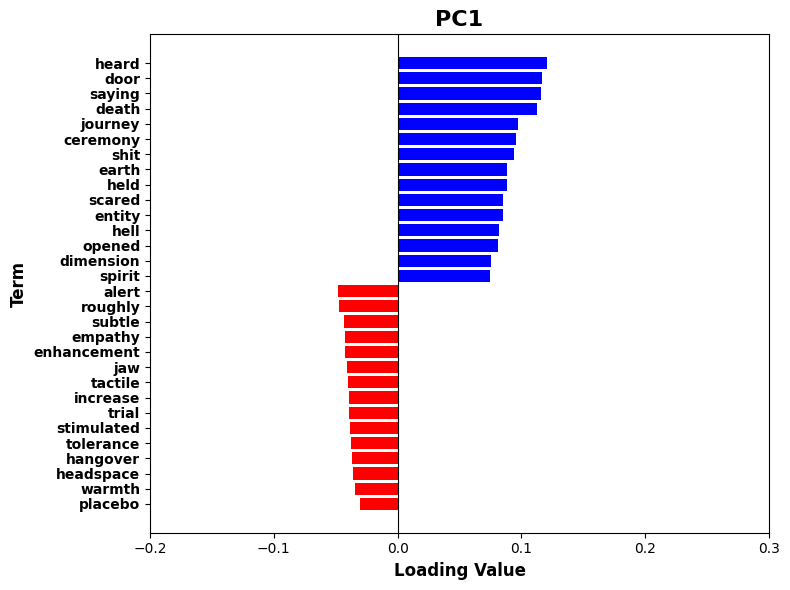

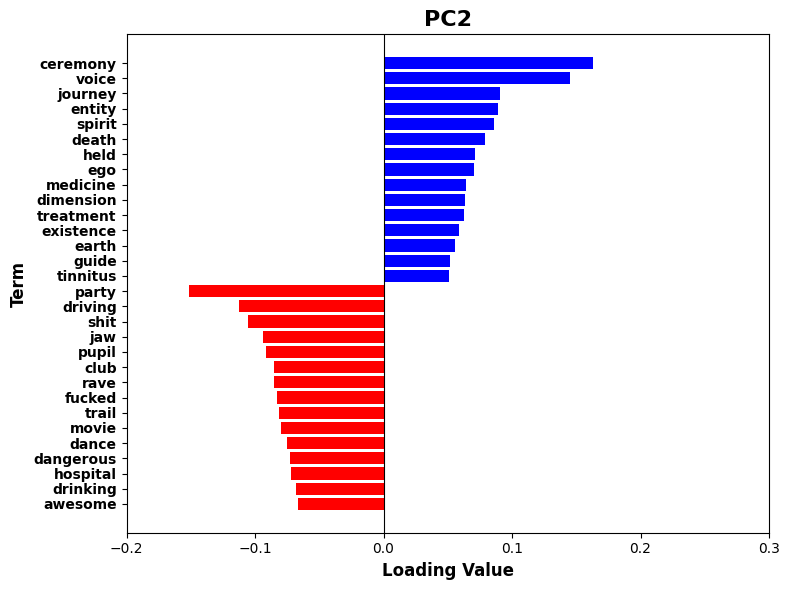

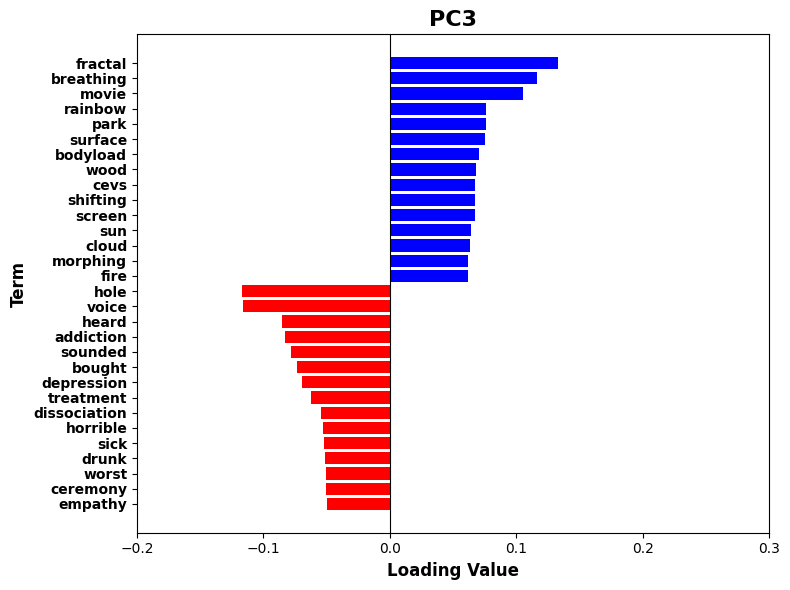

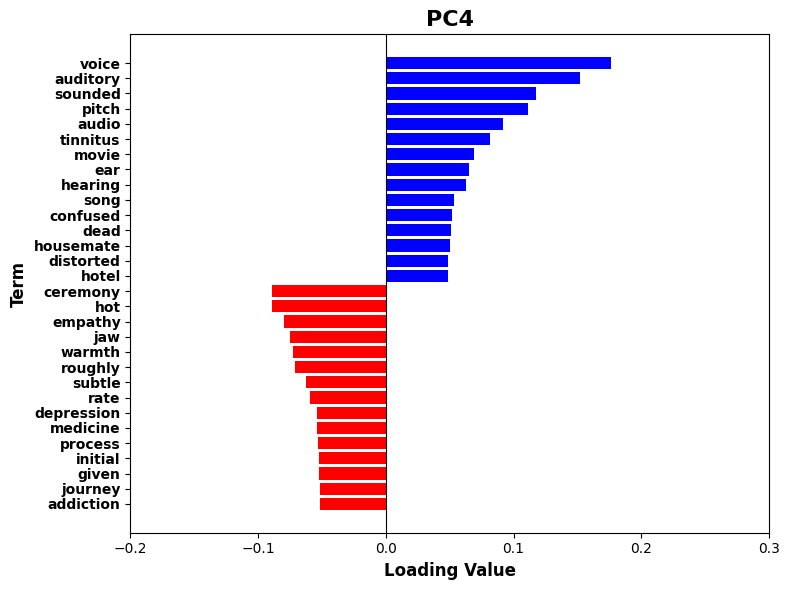

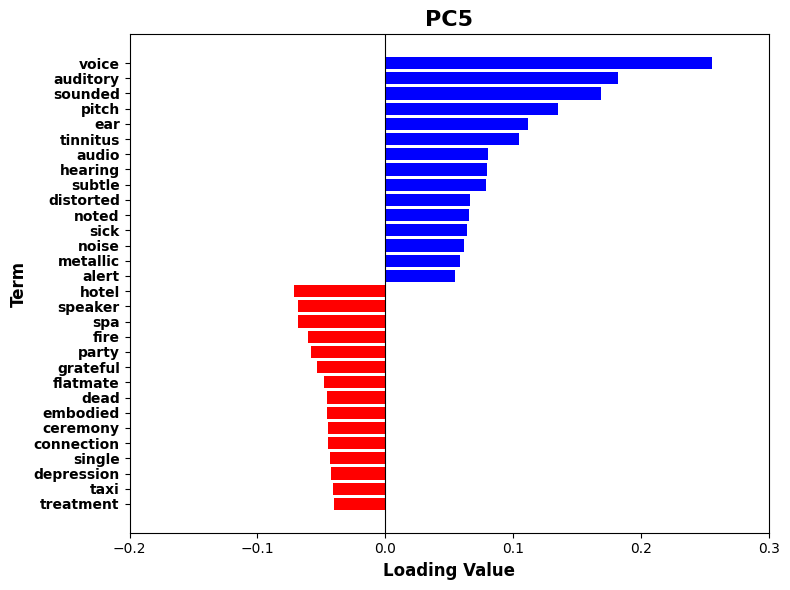

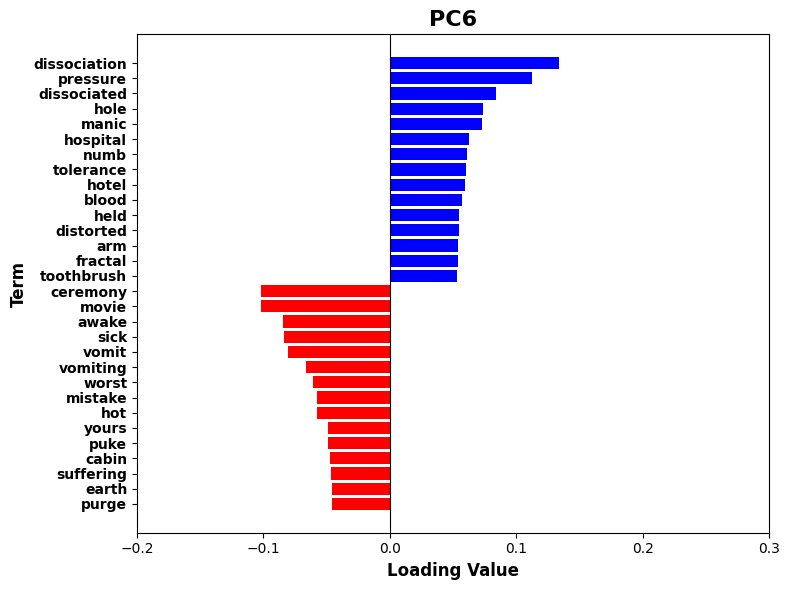

In [ ]:
n_show = 15

for i, pc in enumerate(loadings_df.index):
    vec = loadings_df.loc[pc]
    top_pos = vec.sort_values(ascending=False).head(n_show)
    top_neg = vec.sort_values().head(n_show)

    fig, ax = plt.subplots(figsize=(8, 6))

    combined = pd.concat([top_pos, top_neg])
    colors = ['blue'] * n_show + ['red'] * n_show

    bars = ax.barh(combined.index, combined.values, color=colors)

    # Styling
    ax.set_title(pc, fontsize=16, fontweight='bold')
    ax.set_xlabel("Loading Value", fontsize=12, fontweight='bold')
    ax.set_ylabel("Term", fontsize=12, fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.8)
    ax.invert_yaxis()
    ax.set_xlim(right=0.3, left=-0.2)


    # Bold y-axis labels
    for label in ax.get_yticklabels():
      label.set_fontweight('bold')


    plt.tight_layout()
    plt.show()

# Clustering Post-Hoc

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Transpose so rows are words, columns are PCs
word_loadings = loadings_df.T

scaler = StandardScaler()
X_scaled = scaler.fit_transform(word_loadings.values)

k = 7

kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X_scaled)
word_loadings['cluster'] = clusters

word_loadings['max_loading'] = word_loadings.drop(columns='cluster').abs().max(axis=1)

for c in range(k):
    cluster_words = word_loadings[word_loadings['cluster'] == c]
    top_words = cluster_words.sort_values('max_loading', ascending=False).head(20)
    print(f"\nCluster {c} (Top words):")
    print(top_words.index.tolist())


Cluster 0 (Top words):
['noise', 'metallic', 'housemate', 'godhead', 'cabin', 'ringing', 'twitching', 'deepening', 'jsut', 'speaking', 'sorta', 'clang', 'cody', 'deeper', 'judgement', 'cult', 'harmonic', 'sunrise', 'lateralus', 'sugar']

Cluster 1 (Top words):
['party', 'heard', 'door', 'saying', 'driving', 'movie', 'shit', 'pupil', 'club', 'rave', 'scared', 'fucked', 'hell', 'trail', 'hearing', 'rainbow', 'park', 'dance', 'bought', 'dangerous']

Cluster 2 (Top words):
['fractal', 'subtle', 'surface', 'bodyload', 'wood', 'cevs', 'shifting', 'screen', 'noted', 'morphing', 'colorful', 'oev', 'discomfort', 'flowing', 'character', 'castle', 'texture', 'cat', 'alert', 'neon']

Cluster 3 (Top words):
['voice', 'auditory', 'sounded', 'pitch', 'ear', 'tinnitus', 'audio']

Cluster 4 (Top words):
['dissociation', 'pressure', 'dissociated', 'manic', 'hotel', 'speaker', 'spa', 'distorted', 'numb', 'tolerance', 'blood', 'grateful', 'toothbrush', 'headspace', 'fuzzy', 'lip', 'tooth', 'flatmate', 'p

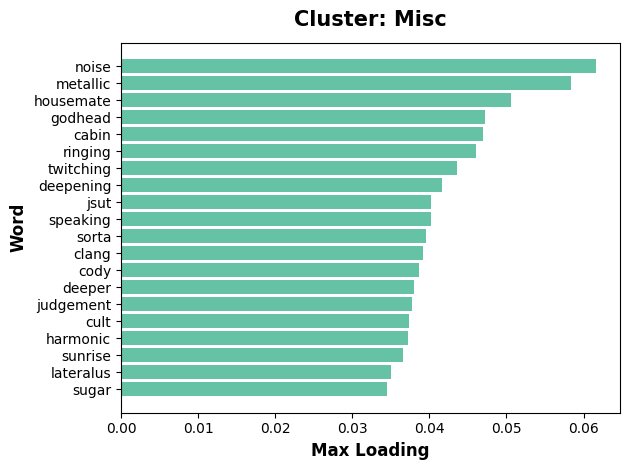

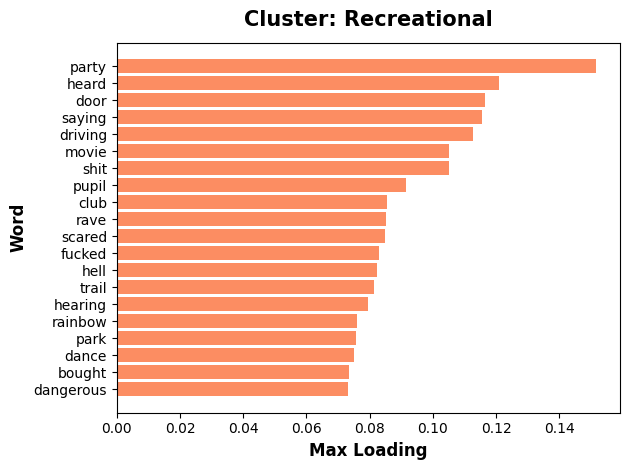

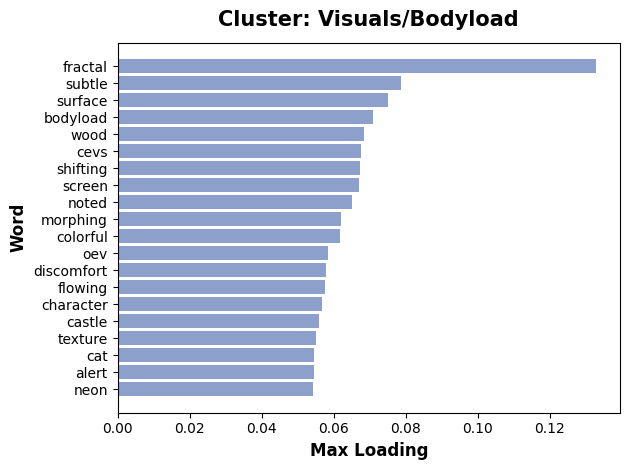

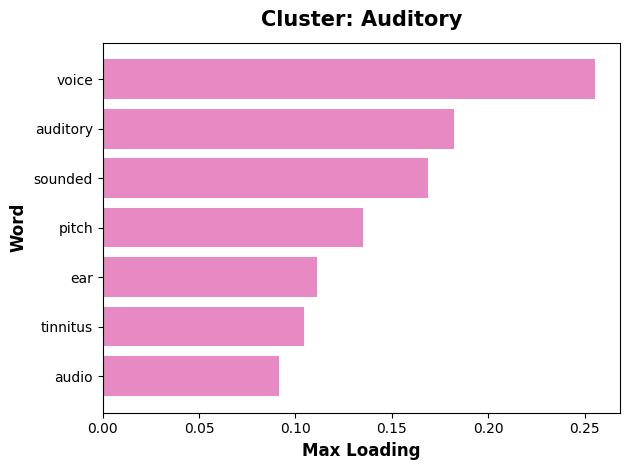

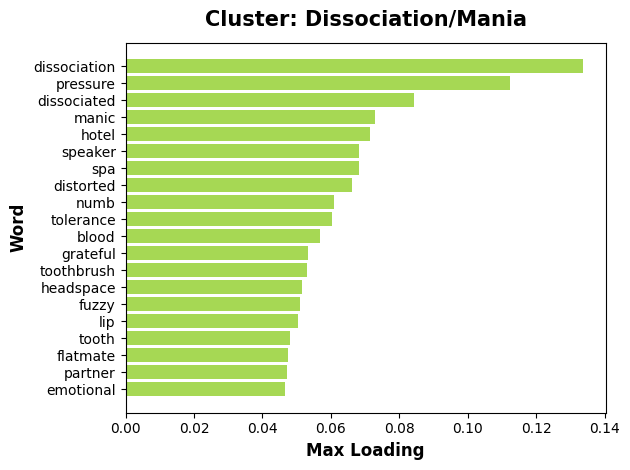

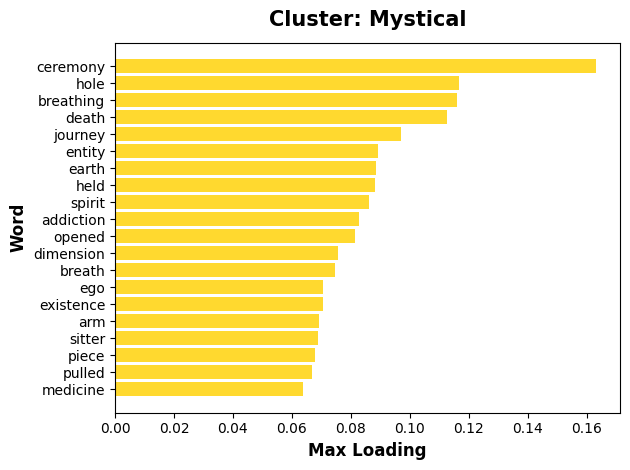

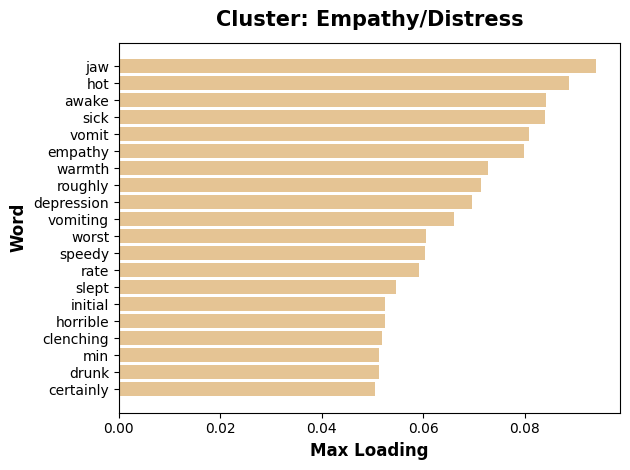

In [ ]:
cluster_names = ['Misc','Recreational', 'Visuals/Bodyload', 'Auditory', 'Dissociation/Mania', 'Mystical', 'Empathy/Distress']

palette = sns.color_palette("Set2", n_colors=k)

for c in range(k):
    cluster_words = word_loadings[word_loadings['cluster'] == c]
    top_words = cluster_words.sort_values('max_loading', ascending=False).head(20)

    bars = plt.barh(
      top_words.index[::-1],
      top_words['max_loading'][::-1],
      color=palette[c]
    )
    plt.title(f"Cluster: {cluster_names[c]}", fontsize=15, fontweight='bold', pad=12)

    plt.xlabel("Max Loading", fontsize=12, fontweight='bold')
    plt.ylabel("Word", fontsize=12, fontweight='bold')

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
# Associate substances with clusters
substance_df = tfidf_group_df.T
substance_df = substance_df[word_loadings.index]
word_clusters = word_loadings.loc[word_loadings.index]['cluster']

cluster_ids = word_clusters.unique()
cluster_ids = sorted(cluster_ids)
cluster_scores = pd.DataFrame(index=substance_df.index, columns=cluster_ids)

for cluster in cluster_ids:
    cluster_words = word_clusters[word_clusters == cluster].index
    cluster_scores[cluster] = substance_df[cluster_words].mean(axis=1)

# Reorder substances and rename clusters to thematic names
cluster_scores = cluster_scores[cluster_scores.columns]
cluster_scores.columns = cluster_names

# Normalize cluster scores to mean and sd = 0
cluster_scores_normalized = cluster_scores.div(cluster_scores.sum(axis=1), axis=0)
cluster_scores_normalized = cluster_scores_normalized.loc[drug_list]

# Semantic Visualization

In [ ]:
def corr_mat(sim_matrix, size1=16, size2=14, subst_class=""):
    plt.figure(figsize=(size1, size2))

    ax = sns.heatmap(
        sim_matrix,
        cmap='coolwarm',
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    ax.set_title('Semantic Similarity Matrix of '+subst_class, fontsize=16, fontweight='bold', pad=10)


    plt.xlabel("Substance", fontsize=14, labelpad=10, fontweight='bold')
    plt.ylabel("Substance", fontsize=14, labelpad=10, fontweight='bold')

    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    plt.tight_layout()

    plt.show()

In [ ]:
def plot_cluster_scores(cluster_scores_normalized, subst_class=""):

    cluster_scores_normalized = cluster_scores_normalized.drop('Misc', axis=1)

    cluster_names = ['Recreational', 'Visuals/Bodyload', 'Auditory', 'Dissociation/Mania', 'Mystical', 'Empathy/Distress']

    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(cluster_scores_normalized, cmap="viridis", cbar=True)

    ax.set_xticks(np.arange(cluster_scores_normalized.shape[1]) + 0.5)
    ax.set_xticklabels(cluster_names, rotation=45, ha='right', fontsize=10, fontweight='bold')

    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, fontweight='bold')

    ax.set_title("Substance × Cluster Association of "+subst_class, fontsize=18, fontweight='bold', pad=15)
    ax.set_xlabel("Cluster", fontsize=14, fontweight='bold')
    ax.set_ylabel("Substance", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


In [ ]:
# See min/max substance for each cluster
def min_max_semantic(df):
  df = df.reset_index()
  results = {}
  for column in df.columns[1:]:
      max_idx = df[column].idxmax()
      min_idx = df[column].idxmin()
      results[column] = {
          'max': (df.loc[max_idx, 'substance'], df.loc[max_idx, column]),
          'min': (df.loc[min_idx, 'substance'], df.loc[min_idx, column])
      }

  # Display results
  for sentiment, extremes in results.items():
      print(f"Category {sentiment}:")
      print(f"  Min: {extremes['min'][0]} ({extremes['min'][1]:.6f})")
      print(f"  Max: {extremes['max'][0]} ({extremes['max'][1]:.6f})\n")

All Substances

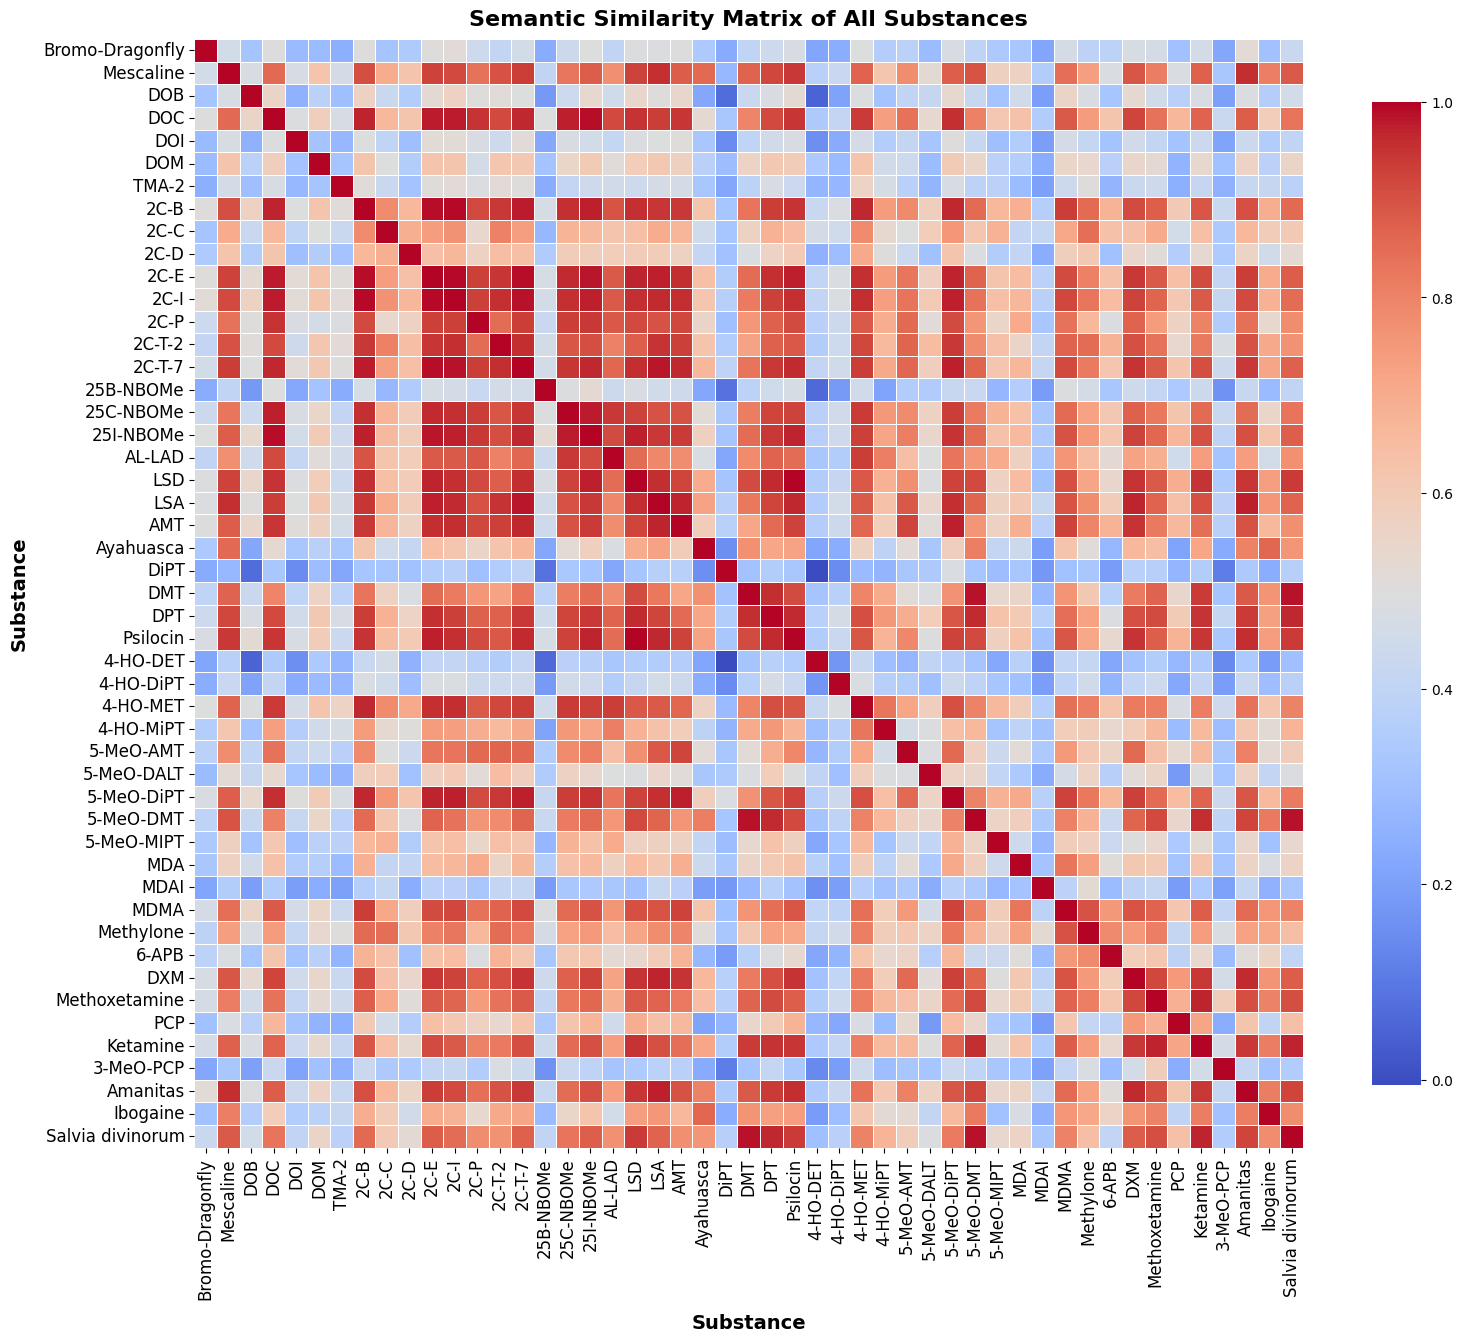

In [ ]:
# Semantic similarity Matrix
corr_mat(sim_matrix, subst_class='All Substances')

In [ ]:
cluster_scores_normalized

,Misc,Recreational,Visuals/Bodyload,Auditory,Dissociation/Mania,Mystical,Empathy/Distress
substance,,,,,,,
Bromo-Dragonfly,0.019769,0.287622,0.032833,0.418445,0.037723,0.136182,0.067426
Mescaline,0.021499,0.257502,0.073105,0.205219,0.055093,0.300967,0.086616
DOB,0.020388,0.372367,0.064623,0.183235,0.084656,0.198451,0.076281
DOC,0.018231,0.356802,0.069893,0.230218,0.063139,0.184575,0.077143
DOI,0.024518,0.349581,0.049654,0.256650,0.036301,0.196144,0.087152
DOM,0.019209,0.254700,0.120167,0.224262,0.074845,0.209282,0.097535
TMA-2,0.013490,0.220905,0.221685,0.183544,0.053300,0.184767,0.122310
2C-B,0.020191,0.343761,0.084563,0.171431,0.071840,0.218182,0.090031
2C-C,0.017805,0.251791,0.157126,0.160202,0.074926,0.179043,0.159106


In [ ]:
min_max_semantic(cluster_scores_normalized)

Category Misc:
  Min: DiPT (0.003710)
  Max: DOI (0.024518)

Category Recreational:
  Min: DiPT (0.030824)
  Max: PCP (0.480993)

Category Visuals/Bodyload:
  Min: DiPT (0.010763)
  Max: TMA-2 (0.221685)

Category Auditory:
  Min: 25B-NBOMe (0.088071)
  Max: DiPT (0.911458)

Category Dissociation/Mania:
  Min: DiPT (0.008425)
  Max: 3-MeO-PCP (0.374282)

Category Mystical:
  Min: DiPT (0.022581)
  Max: Ayahuasca (0.435055)

Category Empathy/Distress:
  Min: DiPT (0.012239)
  Max: MDAI (0.499438)



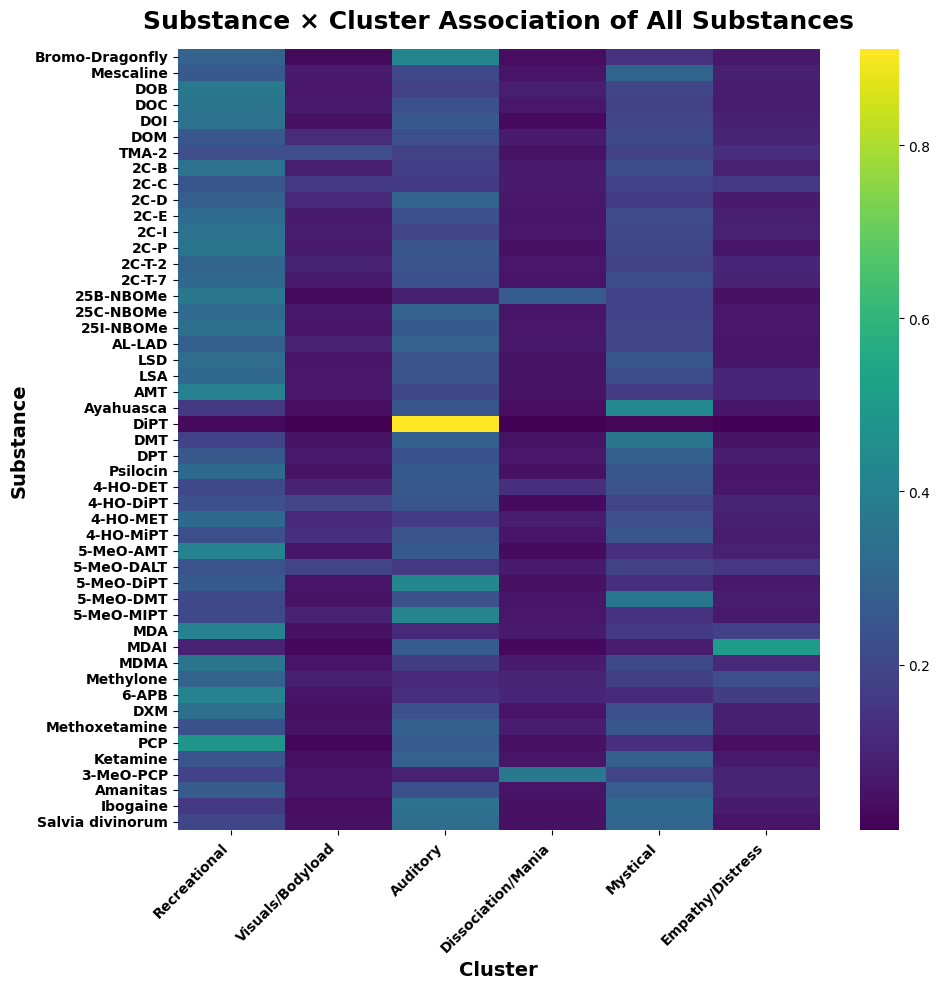

In [ ]:
plot_cluster_scores(cluster_scores_normalized, subst_class='All Substances')

Entactogens

In [ ]:
# Set to entactogens
deprecated_reports, assigned_list = set_assignment('Casey')
assigned_list = assigned_list.iloc[:5]

assigned_sim = sim_matrix.loc[assigned_list, assigned_list]
assigned_cluster_scores = cluster_scores_normalized.loc[assigned_list]

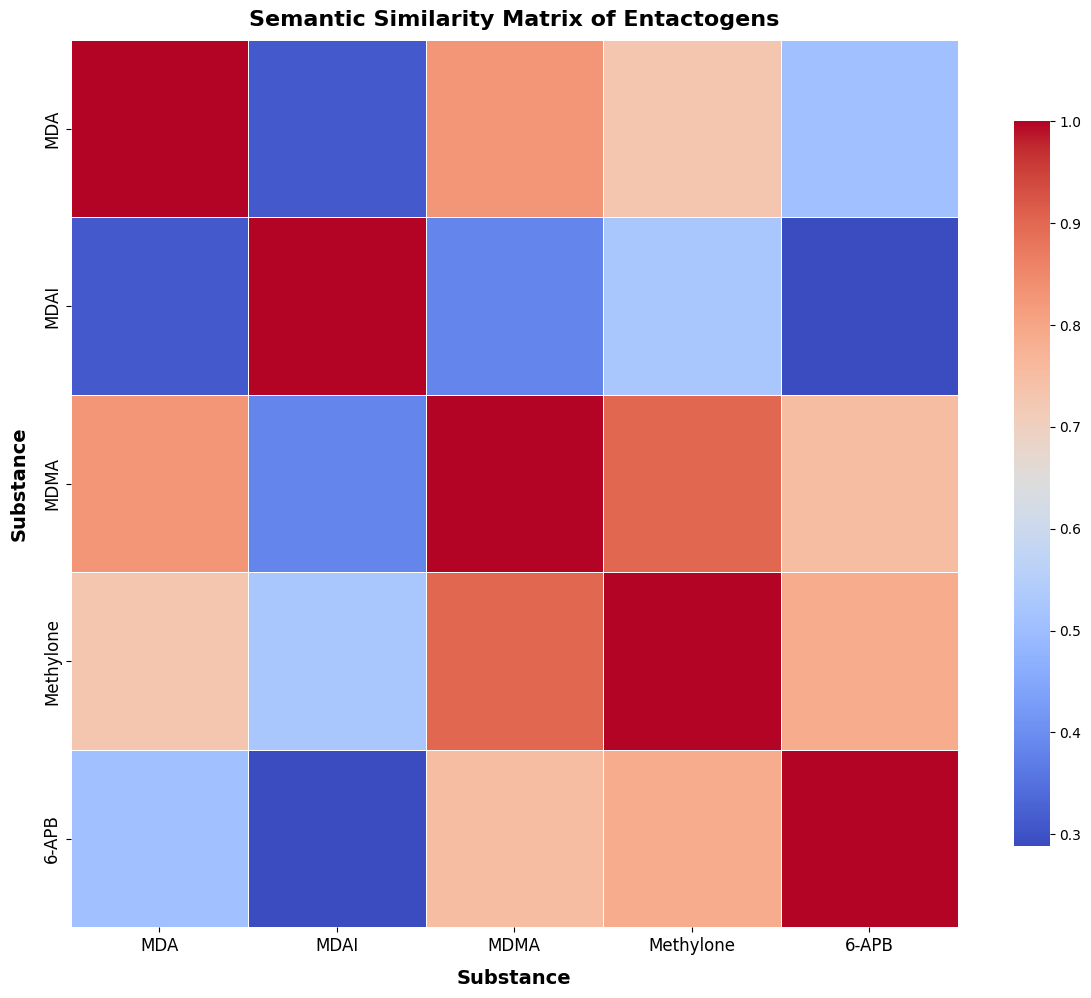

In [ ]:
corr_mat(assigned_sim, 12, 10, subst_class='Entactogens')

In [ ]:
min_max_semantic(assigned_cluster_scores)

Category Misc:
  Min: MDAI (0.004912)
  Max: Methylone (0.019933)

Category Recreational:
  Min: MDAI (0.092804)
  Max: 6-APB (0.409032)

Category Visuals/Bodyload:
  Min: MDAI (0.027220)
  Max: Methylone (0.086095)

Category Auditory:
  Min: Methylone (0.109344)
  Max: MDAI (0.268280)

Category Dissociation/Mania:
  Min: MDAI (0.027923)
  Max: 6-APB (0.102684)

Category Mystical:
  Min: MDAI (0.079422)
  Max: MDMA (0.208854)

Category Empathy/Distress:
  Min: MDMA (0.113263)
  Max: MDAI (0.499438)



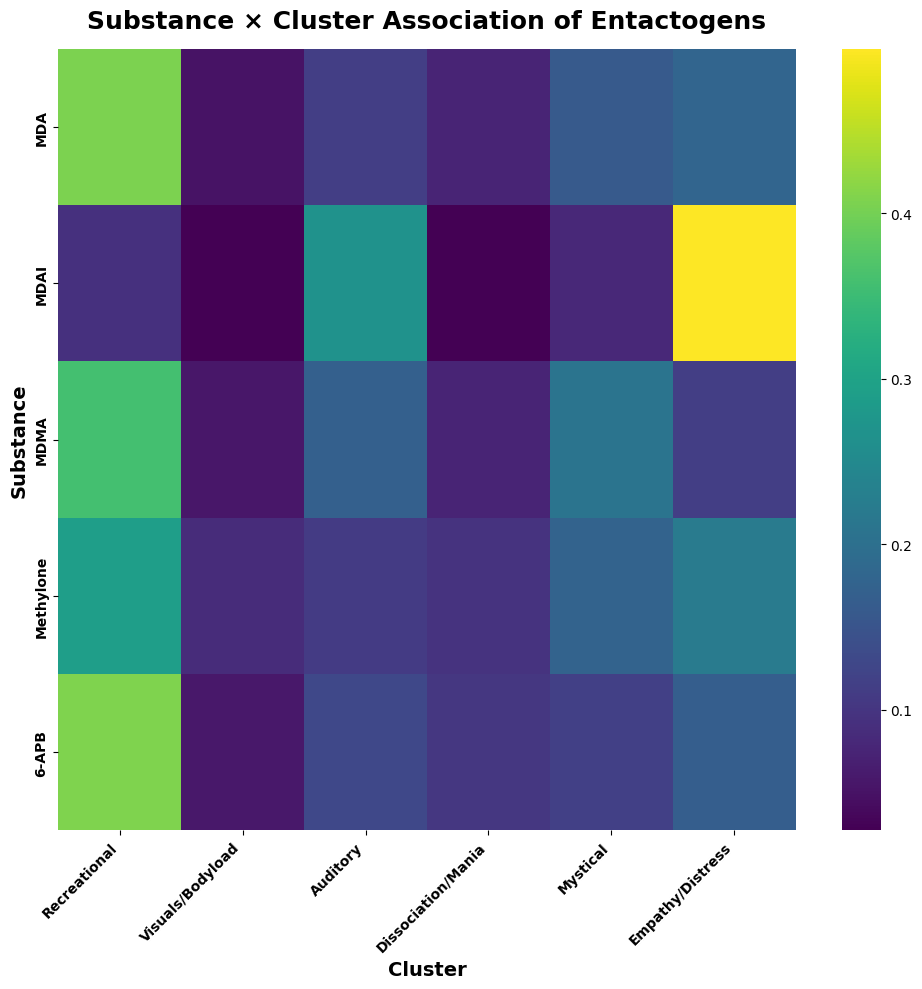

In [ ]:
plot_cluster_scores(assigned_cluster_scores, subst_class='Entactogens')

Lysergamides

In [ ]:
# Set to lysergamides
deprecated_reports, assigned_list = set_assignment('Casey')
assigned_list = assigned_list.iloc[5:8]

assigned_sim = sim_matrix.loc[assigned_list, assigned_list]
assigned_cluster_scores = cluster_scores_normalized.loc[assigned_list]

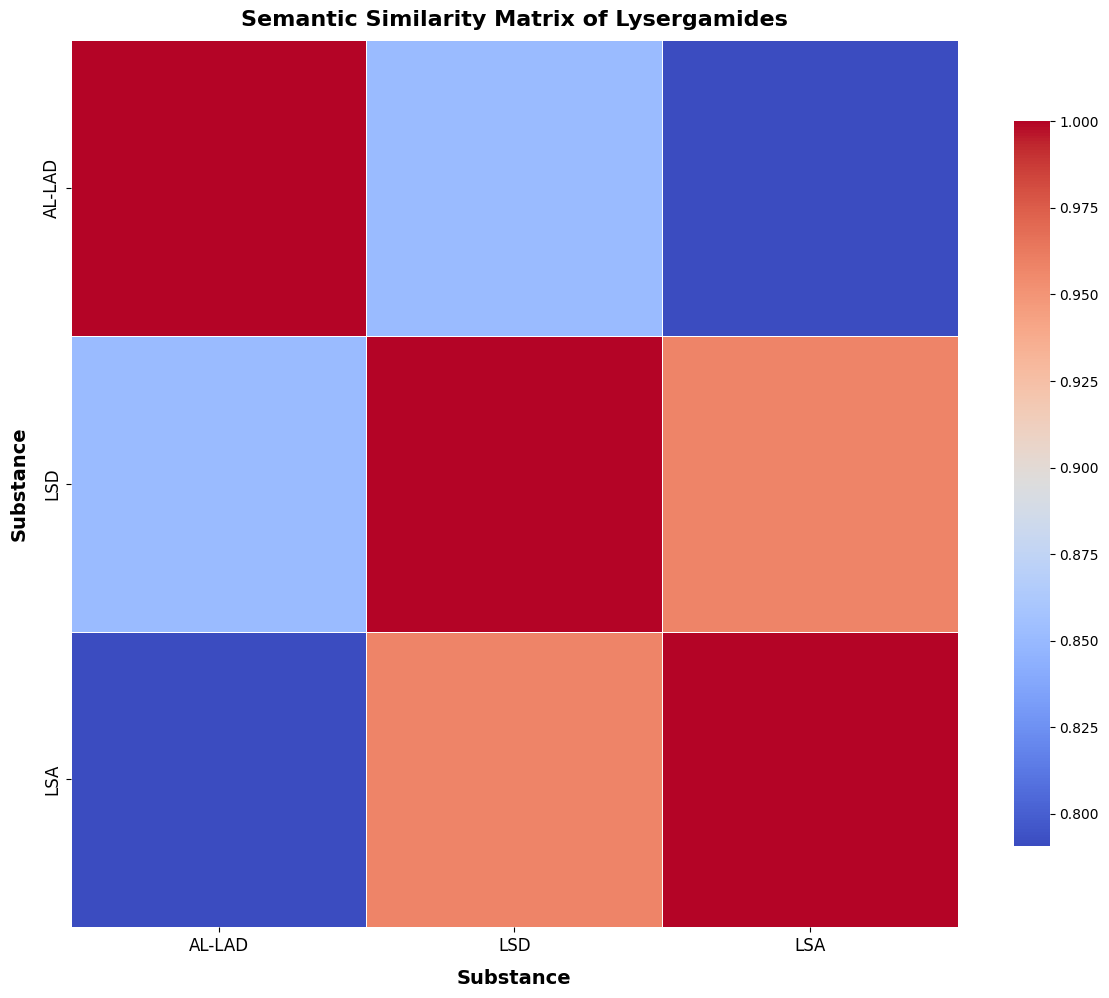

In [ ]:
corr_mat(assigned_sim, 12, 10, subst_class='Lysergamides')

In [ ]:
min_max_semantic(assigned_cluster_scores)

Category Misc:
  Min: AL-LAD (0.015795)
  Max: LSD (0.018901)

Category Recreational:
  Min: AL-LAD (0.282614)
  Max: LSD (0.323465)

Category Visuals/Bodyload:
  Min: LSD (0.054755)
  Max: AL-LAD (0.094175)

Category Auditory:
  Min: LSA (0.237930)
  Max: AL-LAD (0.293733)

Category Dissociation/Mania:
  Min: LSA (0.051521)
  Max: AL-LAD (0.067050)

Category Mystical:
  Min: AL-LAD (0.191982)
  Max: LSD (0.249970)

Category Empathy/Distress:
  Min: AL-LAD (0.054651)
  Max: LSA (0.100257)



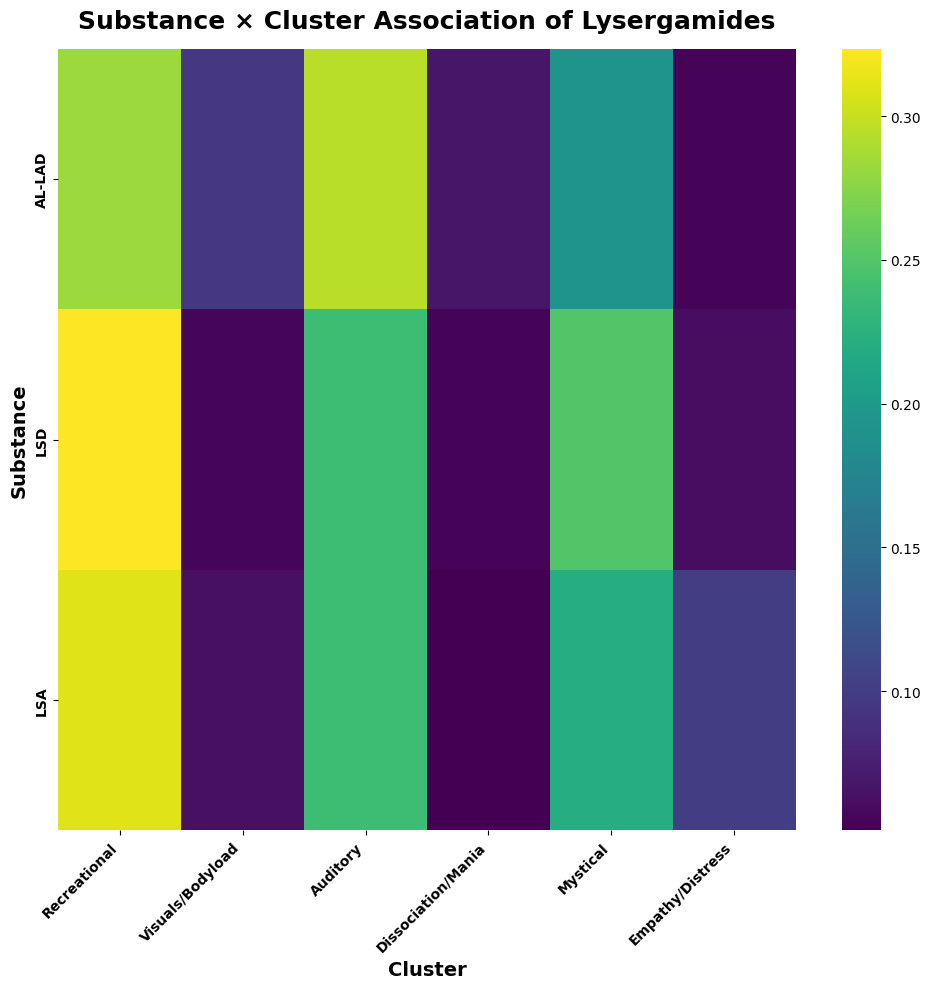

In [ ]:
plot_cluster_scores(assigned_cluster_scores, subst_class='Lysergamides')

Phenethylamines

In [ ]:
# Set to phenethylamines
deprecated_reports, assigned_list = set_assignment('Carlos')

assigned_sim = sim_matrix.loc[assigned_list, assigned_list]
assigned_cluster_scores = cluster_scores_normalized.loc[assigned_list]

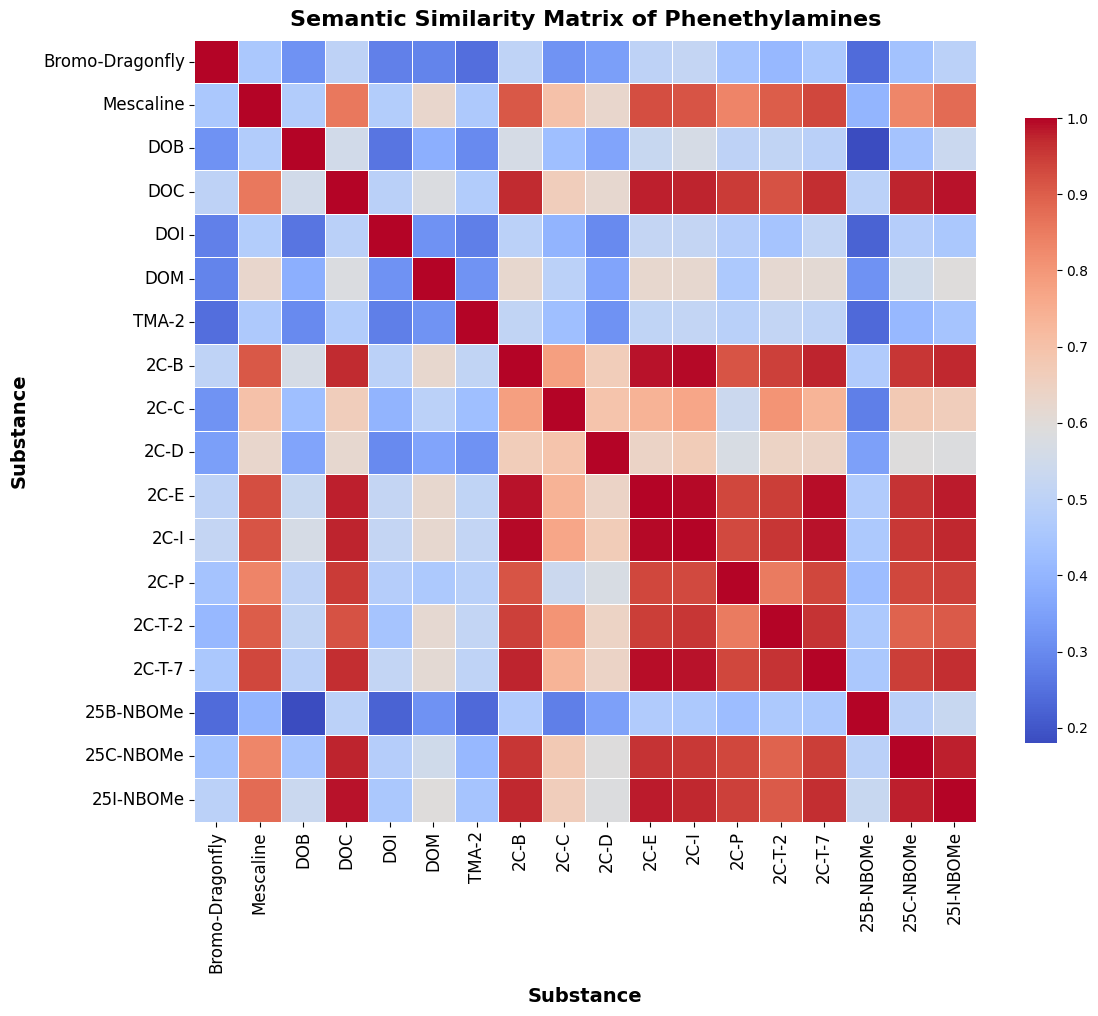

In [ ]:
corr_mat(assigned_sim, 12, 10, subst_class='Phenethylamines')

In [ ]:
min_max_semantic(assigned_cluster_scores)

Category Misc:
  Min: 25B-NBOMe (0.009902)
  Max: DOI (0.024518)

Category Recreational:
  Min: TMA-2 (0.220905)
  Max: DOB (0.372367)

Category Visuals/Bodyload:
  Min: 25B-NBOMe (0.031711)
  Max: TMA-2 (0.221685)

Category Auditory:
  Min: 25B-NBOMe (0.088071)
  Max: Bromo-Dragonfly (0.418445)

Category Dissociation/Mania:
  Min: DOI (0.036301)
  Max: 25B-NBOMe (0.267674)

Category Mystical:
  Min: Bromo-Dragonfly (0.136182)
  Max: Mescaline (0.300967)

Category Empathy/Distress:
  Min: 25B-NBOMe (0.049633)
  Max: 2C-C (0.159106)



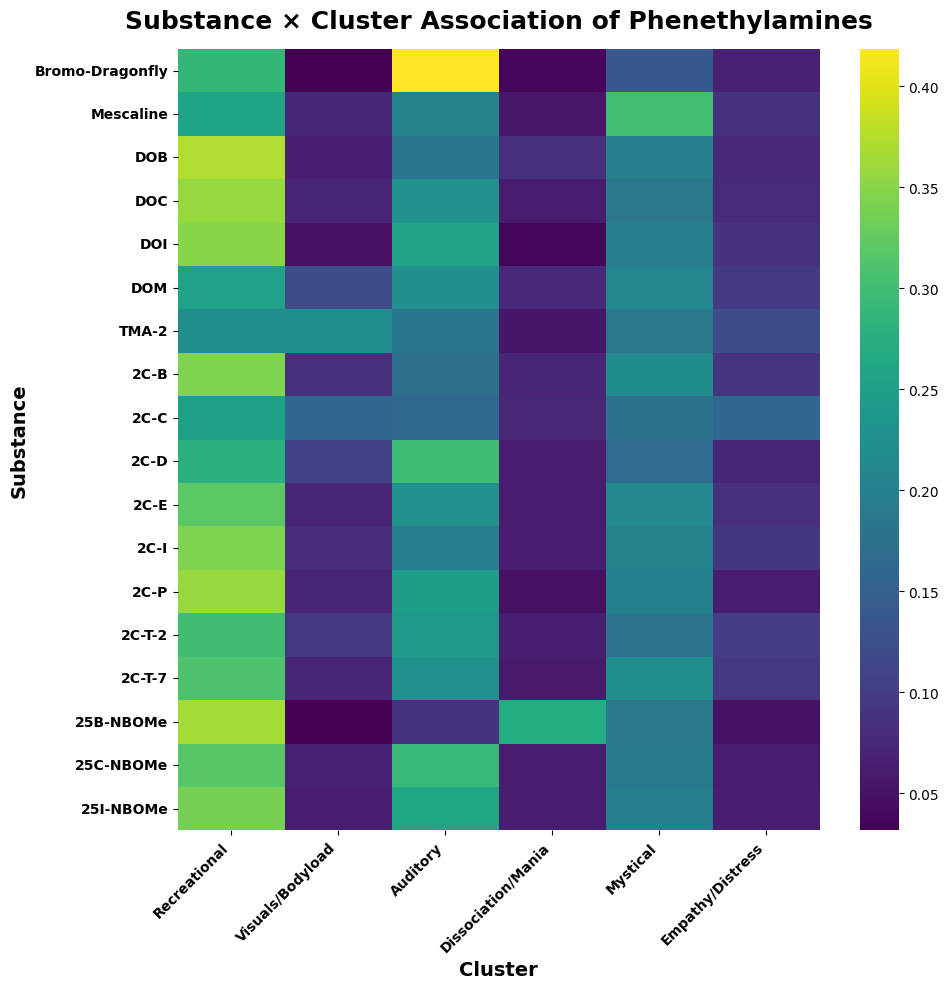

In [ ]:
plot_cluster_scores(assigned_cluster_scores, subst_class='Phenethylamines')

Tryptamines

In [ ]:
# Set to phenethylamines
deprecated_reports, assigned_list = set_assignment('Olivia')

assigned_sim = sim_matrix.loc[assigned_list, assigned_list]
assigned_cluster_scores = cluster_scores_normalized.loc[assigned_list]

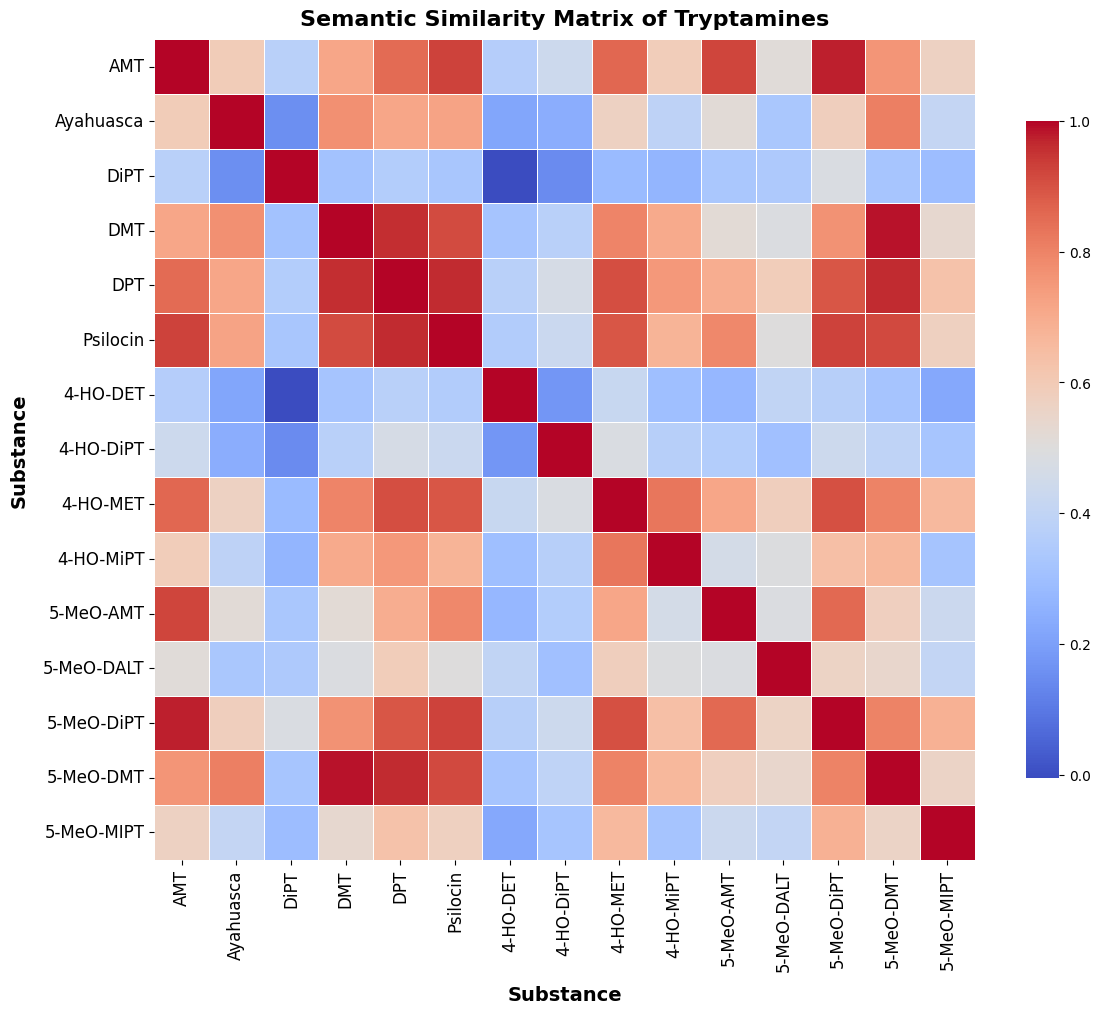

In [ ]:
corr_mat(assigned_sim, 12, 10, subst_class='Tryptamines')

In [ ]:
min_max_semantic(assigned_cluster_scores)

Category Misc:
  Min: DiPT (0.003710)
  Max: 4-HO-DET (0.020418)

Category Recreational:
  Min: DiPT (0.030824)
  Max: 5-MeO-AMT (0.410361)

Category Visuals/Bodyload:
  Min: DiPT (0.010763)
  Max: 4-HO-DiPT (0.188509)

Category Auditory:
  Min: 5-MeO-DALT (0.155589)
  Max: DiPT (0.911458)

Category Dissociation/Mania:
  Min: DiPT (0.008425)
  Max: 4-HO-DET (0.128762)

Category Mystical:
  Min: DiPT (0.022581)
  Max: Ayahuasca (0.435055)

Category Empathy/Distress:
  Min: DiPT (0.012239)
  Max: 5-MeO-DALT (0.152981)



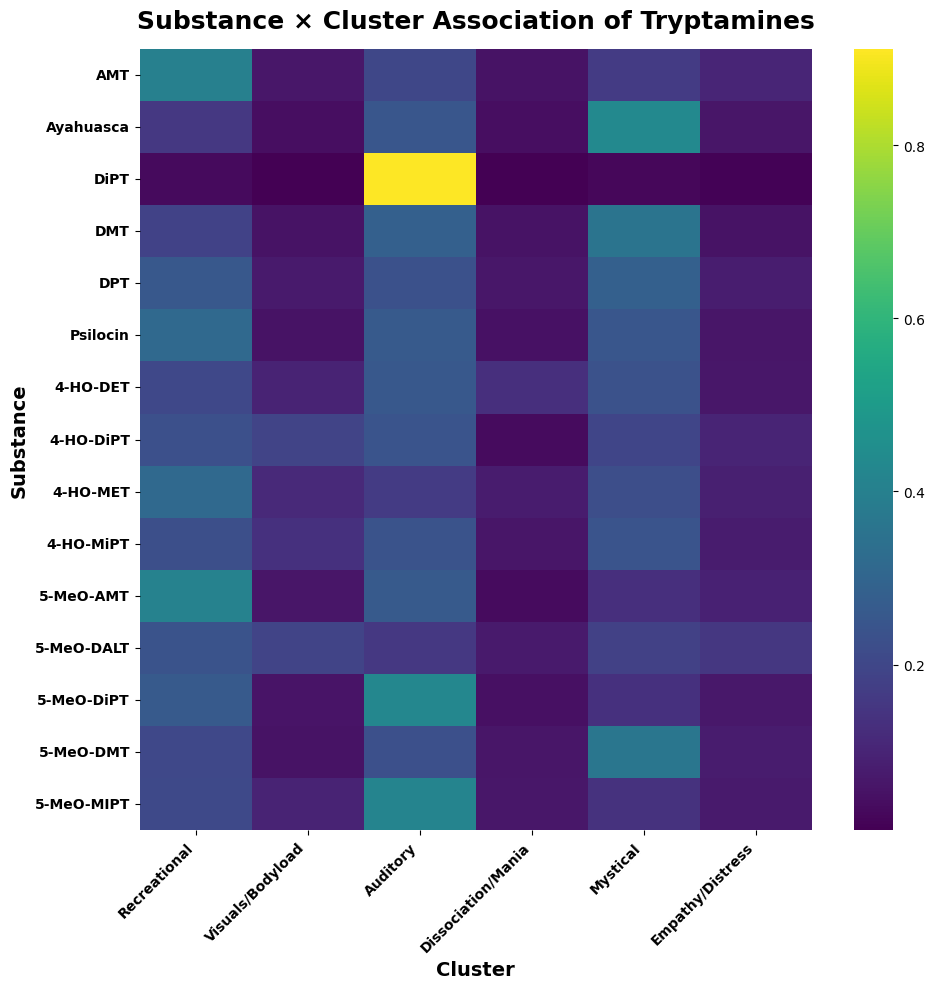

In [ ]:
plot_cluster_scores(assigned_cluster_scores, subst_class='Tryptamines')

Dissosociatives

In [ ]:
# Set to phenethylamines
deprecated_reports, assigned_list = set_assignment('Jacy')

assigned_sim = sim_matrix.loc[assigned_list, assigned_list]
assigned_cluster_scores = cluster_scores_normalized.loc[assigned_list]

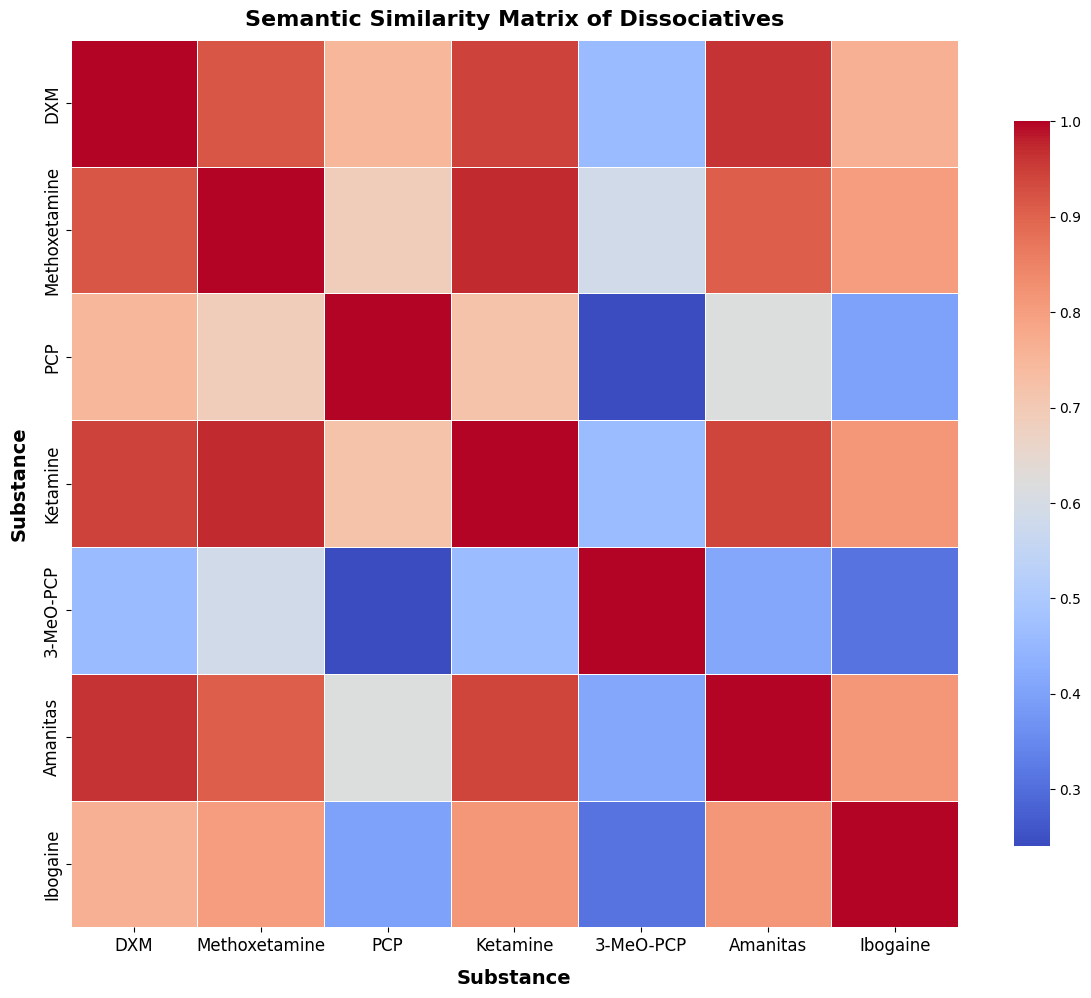

In [ ]:
corr_mat(assigned_sim, 12, 10, subst_class='Dissociatives')

In [ ]:
min_max_semantic(assigned_cluster_scores)

Category Misc:
  Min: 3-MeO-PCP (0.006896)
  Max: Amanitas (0.019914)

Category Recreational:
  Min: Ibogaine (0.159953)
  Max: PCP (0.480993)

Category Visuals/Bodyload:
  Min: PCP (0.022480)
  Max: Amanitas (0.058651)

Category Auditory:
  Min: 3-MeO-PCP (0.091024)
  Max: Ibogaine (0.349669)

Category Dissociation/Mania:
  Min: PCP (0.043990)
  Max: 3-MeO-PCP (0.374282)

Category Mystical:
  Min: PCP (0.131043)
  Max: Ibogaine (0.313488)

Category Empathy/Distress:
  Min: PCP (0.043151)
  Max: 3-MeO-PCP (0.098508)



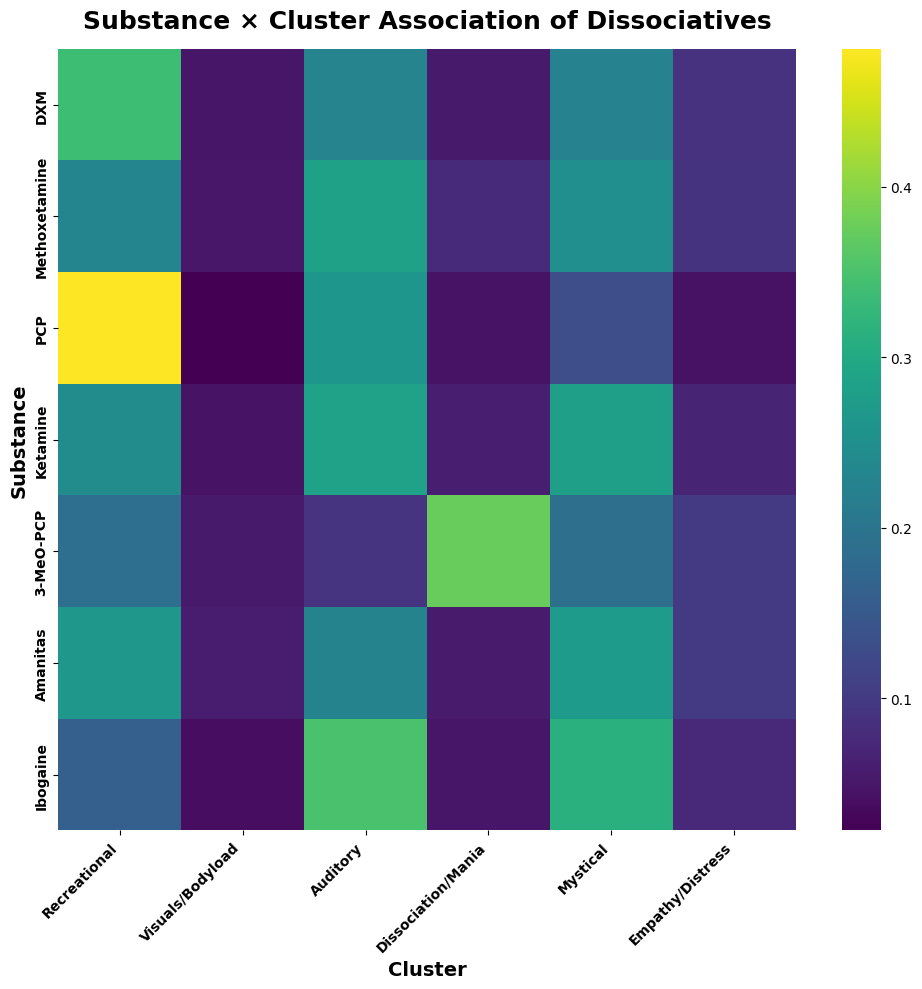

In [ ]:
plot_cluster_scores(assigned_cluster_scores, subst_class='Dissociatives')